# Associations between affect parameters, transdiagnostic mental health, cognitive distancing, and antidepressant use

### Python dependencies

In [1]:
import pandas as pd
import numpy as np
import os, rpy2
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy import stats

pal = ["#ffc9b5", "#648767", "#b1ddf1", "#95a7ce", "#987284", "#3d5a80"]
light_pal = ["#ffc9b5", "#b1ddf1", "#987284"]
dark_pal = ["#648767", "#95a7ce", "#3d5a80"]

pth_fct = 'outputs/factor_prediction'

os.chdir('..')
%load_ext rpy2.ipython

### R dependencies and data

In [2]:
%%R
library(patchwork)
remotes::install_github(
    "qdercon/pstpipeline",
    quiet = TRUE,
    upgrade = "always"
)
# install.packages(c("patchwork", "ggtext"))
# cmdstanr::set_cmdstan_path("/home/qd01/.cmdstanr/cmdstan-2.31.0") 
# extrafont::loadfonts(device = "win", quiet = TRUE) 
    # required on Windows to load additional fonts
options(width = 120)

In [3]:
%%R
pal <- c("#ffc9b5", "#648767", "#b1ddf1", "#95a7ce", "#987284", "#3d5a80")
pal_contr <- c("#ffc9b5", "#95a7ce", "#987284")
pal_recovery <- c("#ffc9b5", "#648767", "#b1ddf1", "#b6b8d6", "#498c8a", "#78ffd6")

all_res_split <- readRDS("data-raw/all_res_split.RDS")
all_res <- purrr::transpose(all_res_split) |> purrr::map(dplyr::bind_rows)

pth <- "outputs/cmdstan/affect_2a/all/model_fits/model_comp/m4/"

summary_df_4wt <- readRDS(paste0(pth, "fit_pst_training_2a_vb_summary.RDS"))
raw_df_4wt <- readRDS(paste0(pth, "fit_pst_training_2a_vb_raw_df.RDS"))

pars <- pstpipeline::make_par_df(
    raw_df_4wt, summary_df_4wt, bsl_trnsfm = function(x) plogis(x)
)

factor_scores <- read.csv("outputs/factor_prediction/all_935_predicted_factor_scores.csv")[-1]

# install.packages("sysfonts")
# sysfonts::font_add_google("Open Sans", "Open Sans")
# showtext::showtext_auto()

## Associations between model parameters and transdiagnostic mental health

First, we take a look at the raw correlations between baseline affect ($w_0$) and each of the three transdiagnostic mental health dimensions of interest - anxiety/depression, compulsive behaviour, and social withdrawal (see ```data_cleaning_factor_derivation.ipynb``` for more information on these).

In [4]:
%%R
cor_test <- function(df, adj, factor) {
  tst <- cor.test(df[df$adj == adj,]$posterior_mean, df[df$adj == adj,][[factor]])
  tibble::tibble(
    "factor" = factor,
    "adj" = adj,
    "est" = tst$estimate[1], 
    "conf_int" = paste0(
      "(", round(tst$conf.int[1], 3), ", ",  round(tst$conf.int[2], 3), ")"
    ), 
    "p_value" = ifelse(
      tst$p.value[1] < 0.0001, "<0.0001", 
      format(round(tst$p.value[1], digits = 4), nsmall = 4, scientific = FALSE))
    )
}

w0_factors_df <- dplyr::filter(
  dplyr::left_join(pars, factor_scores, by = "subjID"), parameter == "w0"
)

dplyr::bind_rows(
  cor_test(w0_factors_df, "happy", "AD"),
  cor_test(w0_factors_df, "happy", "Compul"),
  cor_test(w0_factors_df, "happy", "SW"),
  cor_test(w0_factors_df, "confident", "AD"),
  cor_test(w0_factors_df, "confident", "Compul"),
  cor_test(w0_factors_df, "confident", "SW"),
  cor_test(w0_factors_df, "engaged", "AD"),
  cor_test(w0_factors_df, "engaged", "Compul"),
  cor_test(w0_factors_df, "engaged", "SW"),
)

# A tibble: 9 × 5
  factor adj           est conf_int         p_value
  <chr>  <chr>       <dbl> <chr>            <chr>  
1 AD     happy     -0.270  (-0.329, -0.21)  <0.0001
2 Compul happy     -0.112  (-0.175, -0.048) 0.0006 
3 SW     happy     -0.130  (-0.193, -0.067) <0.0001
4 AD     confident -0.181  (-0.242, -0.118) <0.0001
5 Compul confident -0.0340 (-0.098, 0.03)   0.2992 
6 SW     confident -0.125  (-0.187, -0.061) 0.0001 
7 AD     engaged   -0.164  (-0.225, -0.101) <0.0001
8 Compul engaged   -0.124  (-0.186, -0.06)  0.0001 
9 SW     engaged   -0.0675 (-0.131, -0.003) 0.0390 


Notably, there appears to be strong evidence of a moderate negative correlation between high anxiety/depression scores, and baseline happiness, confidence, and engagement. In addition there is a weaker evidence of negative associations between compulsive behaviour scores and baseline happinesss and engagement, as well as social withdrawal with happiness and confidence.

To investigate this further, we use Bayesian generalised linear models (GLMs), adjusted for age, sex, digit span, and distancing group. The response distribution was assumed to be Gaussian for all weight parameters plus inverse temperatures ($\beta$), and Gamma for learning rates ($\alpha$) and the decay factor ($\gamma$). We primarily focus on the affect-related parameters here given these potential issues with the $Q$-learning parameters.

### Association between anxiety/depression scores and affect model parameters

In [5]:
%%R
AD_affect <- list()

AD_affect$happy <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 1,
  extra_data = factor_scores,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

AD_affect$confident <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 2,
  extra_data = factor_scores,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

AD_affect$engaged <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 3,
  extra_data = factor_scores,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.6 seconds.
Chain 2 finished in 3.6 seconds.
Chain 4 finished in 3.6 seconds.
Chain 3 finished in 3.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.7 seconds.
Total execution time: 3.8 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.0 seconds.
Chain 1 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 3.6 seconds.
Chain 3 finished in 3.6 seconds.
Chain 1 finished in 3.7 seconds.
Chain 4 finished in 3.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.7 seconds.
Total execution time: 3.9 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 4 finished in 3.6 seconds.
Chain 2 finished in 3.6 seconds.
Chain 3 finished in 3.6 seconds.
Chain 1 finished in 3.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.6 seconds.
Total execution time: 3.8 seconds.



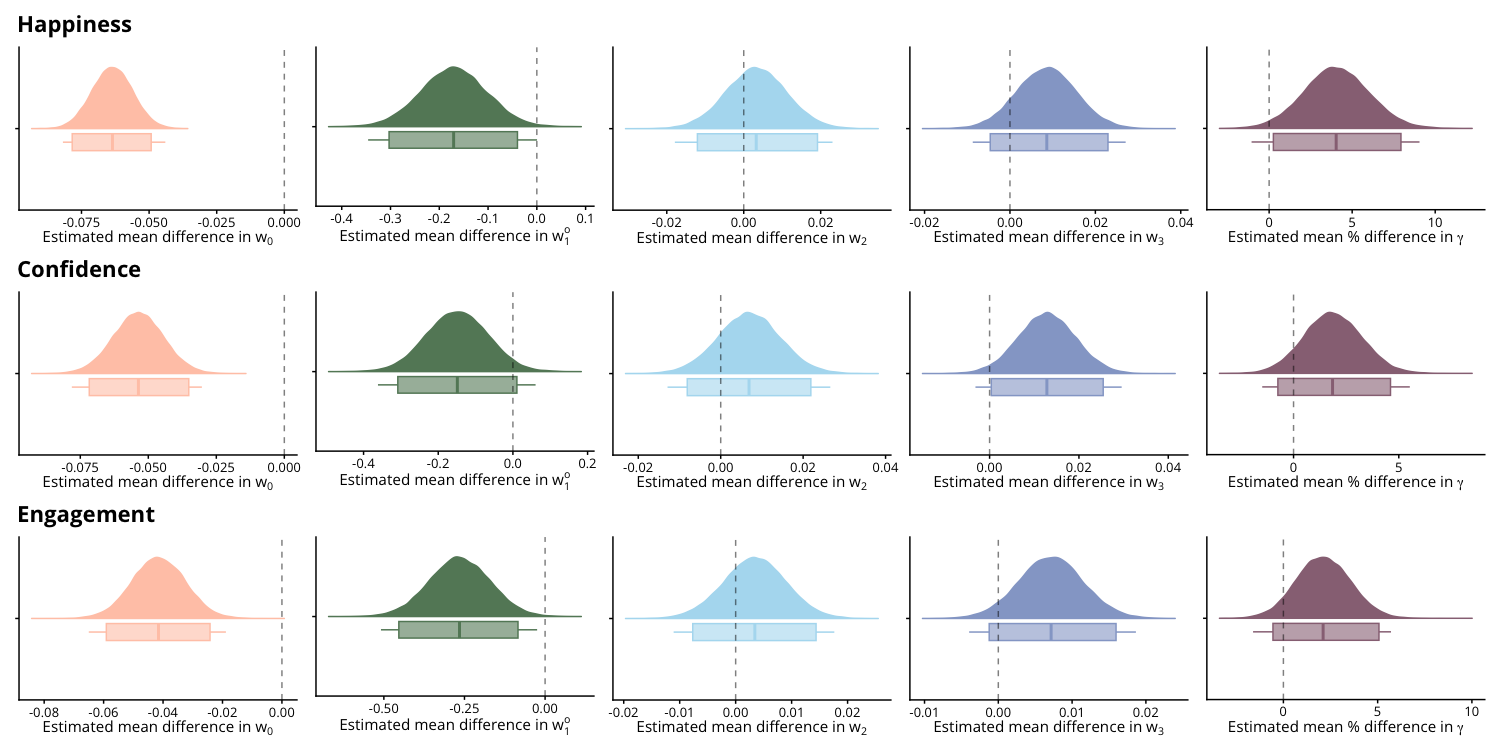

In [6]:
%%R -w 15 -h 7.5 --units in -r 100
library(patchwork)

AD_plt_happy <- pstpipeline::plot_glm(
  AD_affect$happy, plot_var = "AD", font = "Open Sans", pal = pal, ovrll_title = "Happiness"
)
AD_plt_conf <- pstpipeline::plot_glm(
  AD_affect$confident, plot_var = "AD", font = "Open Sans", pal = pal, ovrll_title = "Confidence"
)
AD_plt_bored <- pstpipeline::plot_glm(
  AD_affect$engaged, plot_var = "AD", font = "Open Sans", pal = pal, ovrll_title = "Engagement"
)

AD_plt_happy / AD_plt_conf / AD_plt_bored

Here we again see clear evidence that higher anxiety/depression scores are associated with lower baseline affect ratings, after controlling for age, sex, digit span, and distancing group. However, there is little evidence of an association between anxiety/depression scores and any other model parameter, except for a weak association between higher scores and higher decay factor on $w_2$ and $w_3$ for happiness. This suggests that those with higher anxiety/depression scores incorporate slightly more trials in their calculation of the delay discounted effects of expected value and prediction error. In addition, on average, those with lower anxiety/depression scores appear to decay **more** in happiness and engagement (i.e., higher $w^o_1$) &mdash; this is the opposite of the result reported by [Jangraw *et al.,* 2023](https://www.nature.com/articles/s41562-023-01519-7) in their paper on 'mood drift over time'.

### Association between compulsive behaviour factor scores and model parameters

In [7]:
%%R
CB_affect <- list()

CB_affect$happy <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "Compul",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 1,
  extra_data = factor_scores,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

CB_affect$confident <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "Compul",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 2,
  extra_data = factor_scores,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

CB_affect$engaged <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "Compul",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 3,
  extra_data = factor_scores,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.6 seconds.
Chain 2 finished in 3.6 seconds.
Chain 3 finished in 3.6 seconds.
Chain 4 finished in 3.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.6 seconds.
Total execution time: 3.7 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.6 seconds.
Chain 2 finished in 3.5 seconds.
Chain 4 finished in 3.6 seconds.
Chain 3 finished in 3.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.6 seconds.
Total execution time: 3.7 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.0 seconds.
Chain 1 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 3.6 seconds.
Chain 1 finished in 3.6 seconds.
Chain 3 finished in 3.7 seconds.
Chain 4 finished in 3.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.7 seconds.
Total execution time: 3.9 seconds.



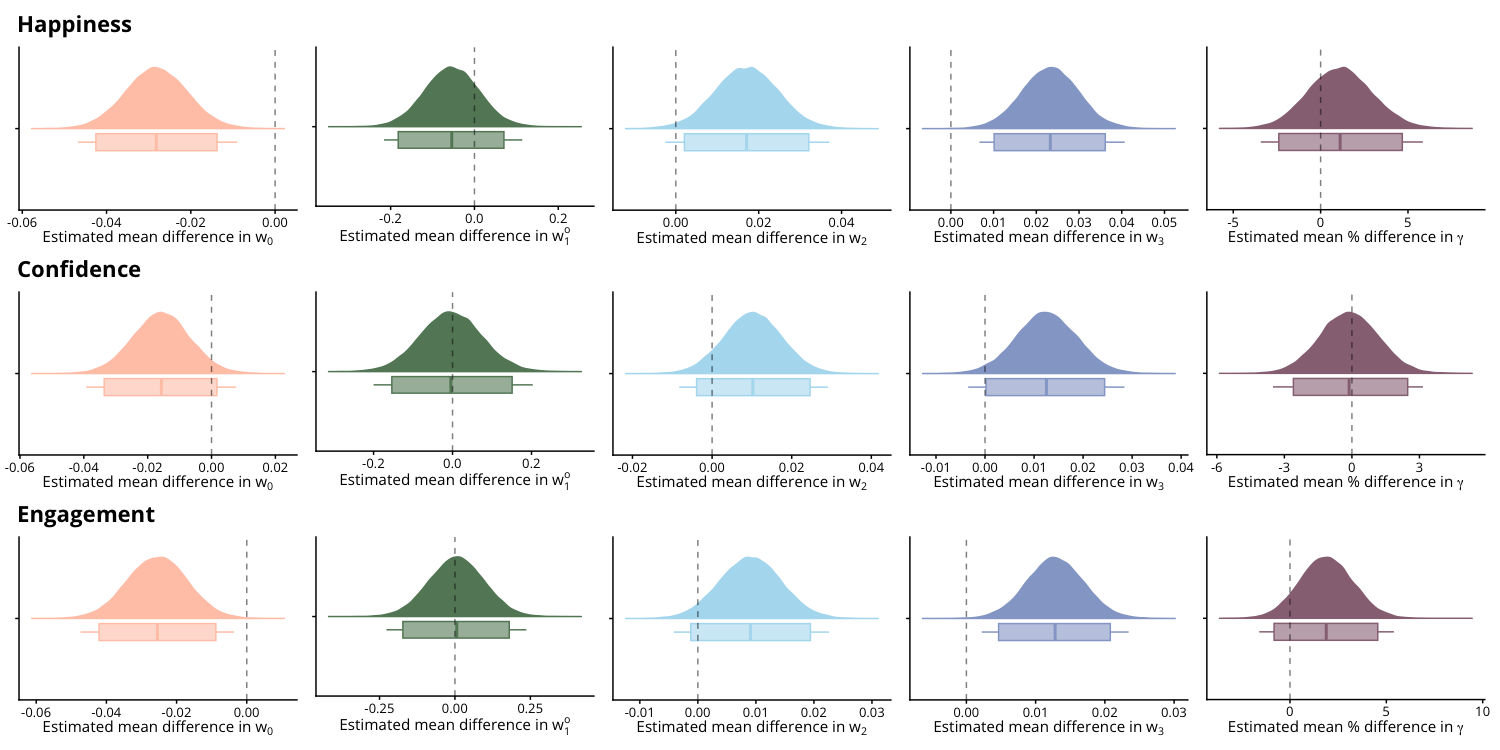

In [8]:
%%R -w 15 -h 7.5 --units in -r 100

CB_plt_happy <- pstpipeline::plot_glm(
  CB_affect$happy, plot_var = "Compul", font = "Open Sans", pal = pal, ovrll_title = "Happiness"
)
CB_plt_conf <- pstpipeline::plot_glm(
  CB_affect$confident, plot_var = "Compul", font = "Open Sans", pal = pal, ovrll_title = "Confidence"
)
CB_plt_bored <- pstpipeline::plot_glm(
  CB_affect$engaged, plot_var = "Compul", font = "Open Sans", pal = pal, ovrll_title = "Engagement"
)

CB_plt_happy / CB_plt_conf / CB_plt_bored

There is evidence that, like anxiety/depression, higher compulsive behaviour factor scores are asssociated with lower baseline happiness and engagement ($w_0$). In addition, those with higher compulsive behaviour scores have higher values for $w_3$, or weights on Q-learning model prediction errors. What this may ultimately translate to is increased fluctuations in score following wins and losses.

### Association between social withdrawal factor scores and model parameters

In [9]:
%%R
SW_affect <- list()

SW_affect$happy <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "SW",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 1,
  extra_data = factor_scores,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

SW_affect$confident <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "SW",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 2,
  extra_data = factor_scores,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

SW_affect$engaged <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "SW",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 3,
  extra_data = factor_scores,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.0 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.6 seconds.
Chain 3 finished in 3.7 seconds.
Chain 4 finished in 3.7 seconds.
Chain 2 finished in 3.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.7 seconds.
Total execution time: 4.0 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.5 seconds.
Chain 2 finished in 3.5 seconds.
Chain 3 finished in 3.5 seconds.
Chain 4 finished in 3.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.6 seconds.
Total execution time: 3.7 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.6 seconds.
Chain 2 finished in 3.5 seconds.
Chain 3 finished in 3.5 seconds.
Chain 4 finished in 3.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.6 seconds.
Total execution time: 3.6 seconds.



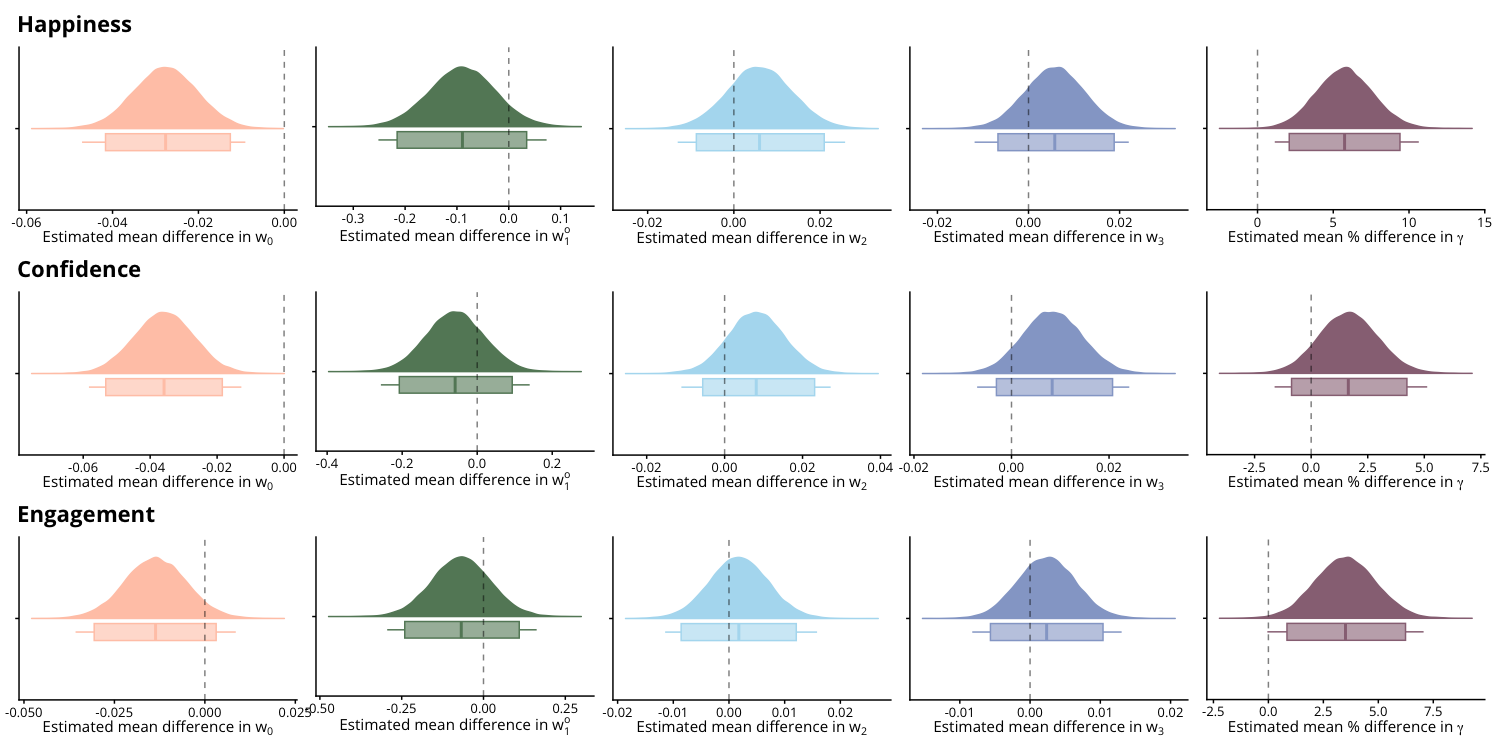

In [10]:
%%R -w 15 -h 7.5 --units in -r 100

SW_plt_happy <- pstpipeline::plot_glm(
  SW_affect$happy, plot_var = "SW", font = "Open Sans", pal = pal, ovrll_title = "Happiness"
)
SW_plt_conf <- pstpipeline::plot_glm(
  SW_affect$confident, plot_var = "SW", font = "Open Sans", pal = pal, ovrll_title = "Confidence"
)
SW_plt_bored <- pstpipeline::plot_glm(
  SW_affect$engaged, plot_var = "SW", font = "Open Sans", pal = pal, ovrll_title = "Engagement"
)

SW_plt_happy / SW_plt_conf / SW_plt_bored

Lastly, for social withdrawal factor scores, higher scores are associated again with lower baseline happiness, as well as lower baseline confidence, but not lower baseline engagement. There is limited evidence of any association with any other model parameters, except for higher decay factors for both happiness and engagement (slightly higher weighting of historical trial outcomes).

In [11]:
%%R
transdiag_aff_mods <- list()
transdiag_aff_mods$AD <- AD_affect
transdiag_aff_mods$CB <- CB_affect
transdiag_aff_mods$SW <- SW_affect

dir.create("outputs/cmdstan/affect_2a/outcome_glms")
saveRDS(transdiag_aff_mods, "outputs/cmdstan/affect_2a/outcome_glms/transdiag_affect_models.RDS")

## Associations between model parameters and cognitive distancing & antidepressant use

First, we take a look to see whether we can replicate our previous findings - that cognitive distancing is associated with higher inverse temperatures ($\beta$) and late-stage increases in negative learning rates ($\alpha_{loss}$) during the probabilistic selection task.

In [12]:
%%R
dist_models <- list()
dist_models$dist_QL_affect <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "distanced",
  covariates = c("age", "sex", "digit_span"),
  iter_warmup = 2000, iter_sampling = 10000
)

antidep_models <- list()
antidep_models$antidep_QL_affect <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "antidepressant",
  recode_na = 0,
  covariates = c("age", "sex", "digit_span", "distanced"),
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.6 seconds.
Chain 2 finished in 3.6 seconds.
Chain 3 finished in 3.6 seconds.
Chain 4 finished in 3.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.6 seconds.
Total execution time: 3.7 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.9 seconds.
Chain 3 finished in 3.9 seconds.
Chain 4 finished in 3.9 seconds.
Chain 2 finished in 3.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.9 seconds.
Total execution time: 4.0 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.7 seconds.
Chain 2 finished in 3.8 seconds.
Chain 3 finished in 3.7 seconds.
Chain 4 finished in 3.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.8 seconds.
Total execution time: 3.8 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.9 seconds.
Chain 2 finished in 3.9 seconds.
Chain 3 finished in 3.9 seconds.
Chain 4 finished in 3.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.9 seconds.
Total execution time: 4.0 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



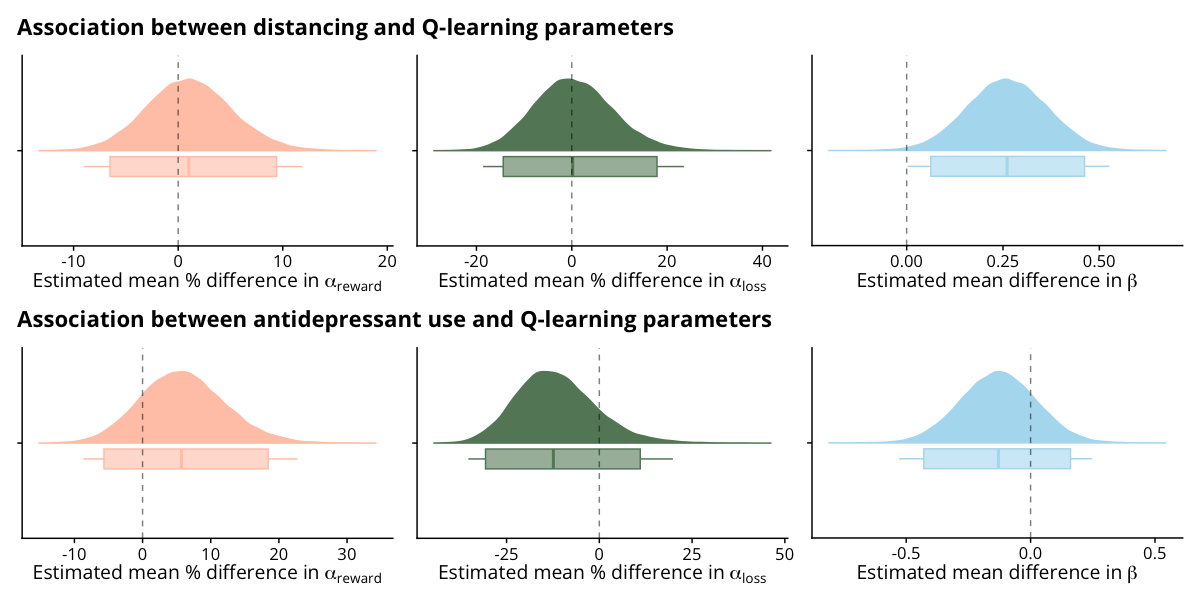

In [13]:
%%R -w 12 -h 6 --units in -r 100
dist_plt_QL <- pstpipeline::plot_glm(
  dist_models$dist_QL_affect, plot_var = "distanced", alpha_par_nms = c("reward", "loss"), 
  font = "Open Sans", font_size = 14, pal = pal,
  ovrll_title = "Association between distancing and Q-learning parameters"
)
antidep_plt_QL <- pstpipeline::plot_glm(
  antidep_models$antidep_QL_affect, plot_var = "antidepressant", 
  alpha_par_nms = c("reward", "loss"), 
  font = "Open Sans", font_size = 14, pal = pal, 
  ovrll_title = "Association between antidepressant use and Q-learning parameters"
)

dist_plt_QL / antidep_plt_QL

Interestingly, we replicate our [previous finding](doi.org/10.1017/S0033291723001587) that the distanced group appear to have higher inverse temperatures by the end of training. However, differences in learning rates are not seen in this model - this may be simply due to the joint increment of the model log density on the choice and affect models, and may also be explained by the fact this finding appeared only to emerge late in the task in our earlier work. In addition, there is little evidence for any specific effect of antidepressant use on the learning parameters in this task.

### Cognitive distancing

In [14]:
%%R
dist_models$happy <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "distanced",
  covariates = c("age", "sex", "digit_span"),
  affect_number = 1,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

dist_models$confident <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "distanced",
  covariates = c("age", "sex", "digit_span"),
  affect_number = 2,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

dist_models$engaged <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "distanced",
  covariates = c("age", "sex", "digit_span"),
  affect_number = 3,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 0.9 seconds.
Chain 2 finished in 0.9 seconds.
Chain 3 finished in 0.9 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.9 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 0.9 seconds.
Chain 2 finished in 0.9 seconds.
Chain 3 finished in 0.9 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.9 seconds.
Total execution time: 1.0 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 0.9 seconds.
Chain 2 finished in 0.9 seconds.
Chain 3 finished in 0.9 seconds.
Chain 4 finished in 0.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.9 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.5 seconds.
Chain 2 finished in 3.5 seconds.
Chain 4 finished in 3.5 seconds.
Chain 3 finished in 3.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.5 seconds.
Total execution time: 3.7 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 0.9 seconds.
Chain 2 finished in 0.9 seconds.
Chain 3 finished in 0.9 seconds.
Chain 4 finished in 0.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.9 seconds.
Total execution time: 1.0 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 0.9 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 0.9 seconds.
Chain 2 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 0.9 seconds.
Chain 2 finished in 0.9 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.9 seconds.
Total execution time: 1.0 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 0.9 seconds.
Chain 2 finished in 0.9 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 0.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.9 seconds.
Total execution time: 1.0 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.4 seconds.
Chain 2 finished in 3.5 seconds.
Chain 4 finished in 3.4 seconds.
Chain 3 finished in 3.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.5 seconds.
Total execution time: 3.6 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 0.9 seconds.
Chain 1 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 0.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 0.9 seconds.
Chain 2 finished in 0.9 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 0.9 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.4 seconds.
Chain 4 finished in 3.4 seconds.
Chain 2 finished in 3.6 seconds.
Chain 3 finished in 3.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.5 seconds.
Total execution time: 3.6 seconds.



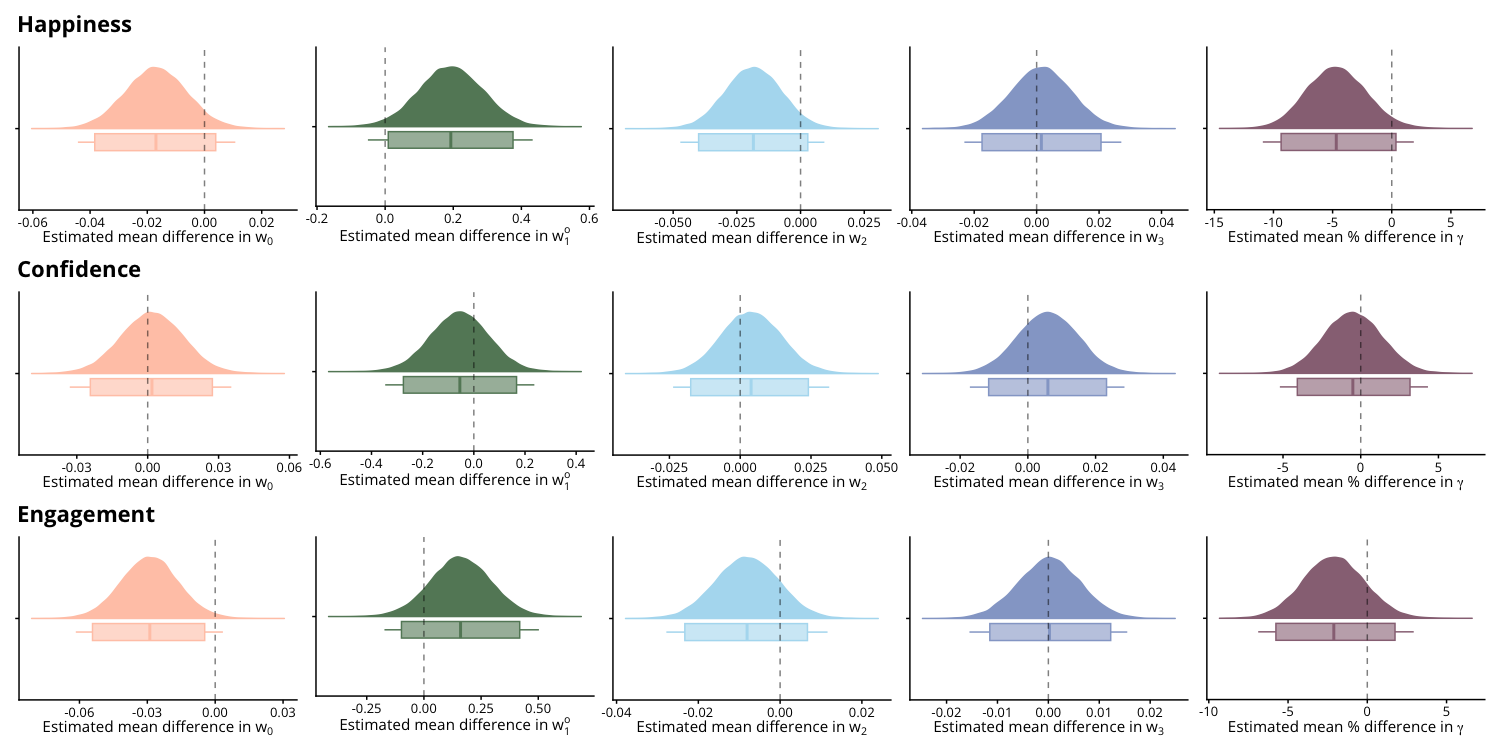

In [15]:
%%R -w 15 -h 7.5 --units in -r 100

dist_plt_happy <- pstpipeline::plot_glm(
  dist_models$happy, plot_var = "distanced", font = "Open Sans", pal = pal, ovrll_title = "Happiness"
)
dist_plt_conf <- pstpipeline::plot_glm(
  dist_models$confident, plot_var = "distanced", font = "Open Sans", pal = pal, ovrll_title = "Confidence"
)
dist_plt_bored <- pstpipeline::plot_glm(
  dist_models$engaged, plot_var = "distanced", font = "Open Sans", pal = pal, ovrll_title = "Engagement"
)

dist_plt_happy / dist_plt_conf / dist_plt_bored

These results indicate that participants in the distancing group differed only with respect to their baseline and decay in affect throughout the task. Distanced individuals decayed less across the task in terms of happiness (higher $w^o_1$) despite lower baseline engagement, and also decayed slightly less in engagement, though this finding is weak. Notably, these results also replicate those from simple analyses found in our [earlier work](doi.org/10.1017/S0033291723001587), where we found in multilevel models with a random intercept for participant ID that distanced participants decreased less in happiness and engagement, but not confidence, over the course of the task.

### Antidepressant use

Given that this treatment was not randomised, we additionally consider whether observed associations were independent of anxiety/depression symptom scores.

In [16]:
%%R
antidep_models$happy <- list()
antidep_models$confident <- list()
antidep_models$engaged <- list()

# happiness

antidep_models$happy$no_AD <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "antidepressant",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 1, recode_na = 0,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)
antidep_models$happy$AD <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "antidepressant",
  covariates = c("age", "sex", "digit_span", "distanced", "AD"),
  affect_number = 1, recode_na = 0,
  extra_data = factor_scores,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

# confidence

antidep_models$confident$no_AD <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "antidepressant",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 2, recode_na = 0,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)
antidep_models$confident$AD <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "antidepressant",
  covariates = c("age", "sex", "digit_span", "distanced", "AD"),
  affect_number = 2, recode_na = 0,
  extra_data = factor_scores,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

# engagement

antidep_models$engaged$no_AD <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "antidepressant",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 3, recode_na = 0,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)
antidep_models$engaged$AD <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "antidepressant",
  covariates = c("age", "sex", "digit_span", "distanced", "AD"),
  affect_number = 3, recode_na = 0,
  extra_data = factor_scores,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.6 seconds.
Chain 2 finished in 3.6 seconds.
Chain 3 finished in 3.6 seconds.
Chain 4 finished in 3.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.7 seconds.
Total execution time: 3.9 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.1 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.2 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 3.7 seconds.
Chain 3 finished in 3.7 seconds.
Chain 1 finished in 3.8 seconds.
Chain 4 finished in 3.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.8 seconds.
Total execution time: 3.9 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.0 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.6 seconds.
Chain 3 finished in 3.6 seconds.
Chain 4 finished in 3.6 seconds.
Chain 2 finished in 3.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.6 seconds.
Total execution time: 3.8 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.2 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 4 finished in 3.6 seconds.
Chain 1 finished in 3.7 seconds.
Chain 2 finished in 3.8 seconds.
Chain 3 finished in 4.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.8 seconds.
Total execution time: 4.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.0 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.
Chain 3 finished in 1.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.2 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 3.6 seconds.
Chain 4 finished in 3.6 seconds.
Chain 1 finished in 3.7 seconds.
Chain 2 finished in 3.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.6 seconds.
Total execution time: 3.8 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 3.6 seconds.
Chain 4 finished in 3.6 seconds.
Chain 1 finished in 3.7 seconds.
Chain 3 finished in 4.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.7 seconds.
Total execution time: 4.1 seconds.



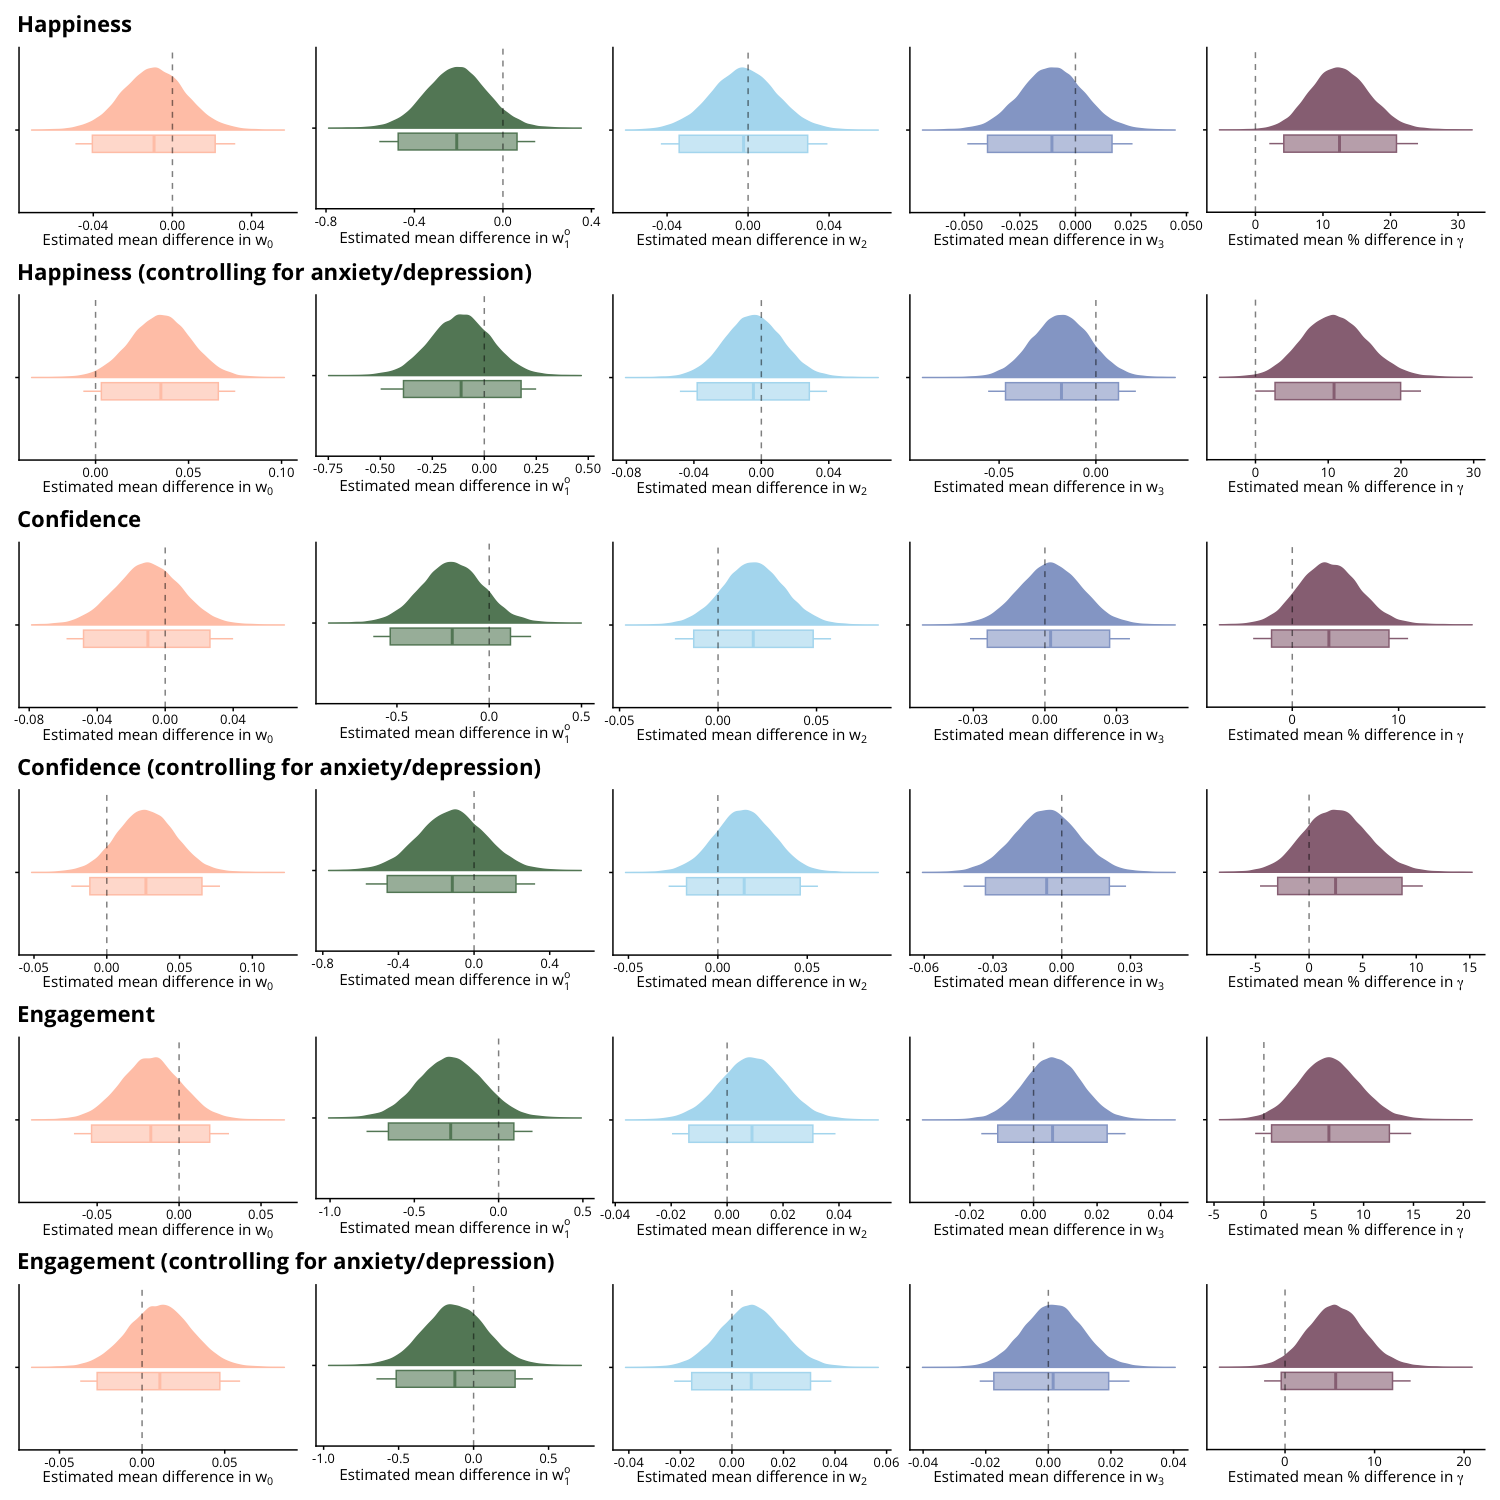

In [17]:
%%R -w 15 -h 15 --units in -r 100

antidep_plt_happy <- pstpipeline::plot_glm(
  antidep_models$happy$no_AD, plot_var = "antidepressant", font = "Open Sans", pal = pal, ovrll_title = "Happiness"
)
antidep_plt_happy_ad <- pstpipeline::plot_glm(
  antidep_models$happy$AD, plot_var = "antidepressant", font = "Open Sans", pal = pal, 
  ovrll_title = "Happiness (controlling for anxiety/depression)"
)

antidep_plt_conf <- pstpipeline::plot_glm(
  antidep_models$confident$no_AD, plot_var = "antidepressant", font = "Open Sans", pal = pal, ovrll_title = "Confidence"
)
antidep_plt_conf_ad <- pstpipeline::plot_glm(
  antidep_models$confident$AD, plot_var = "antidepressant", font = "Open Sans", pal = pal, 
  ovrll_title = "Confidence (controlling for anxiety/depression)"
)

antidep_plt_bored <- pstpipeline::plot_glm(
  antidep_models$engaged$no_AD, plot_var = "antidepressant", font = "Open Sans", pal = pal, ovrll_title = "Engagement"
)
antidep_plt_bored_ad <- pstpipeline::plot_glm(
  antidep_models$engaged$AD, plot_var = "antidepressant", font = "Open Sans", pal = pal, 
  ovrll_title = "Engagement (controlling for anxiety/depression)"
)

antidep_plt_happy / antidep_plt_happy_ad / antidep_plt_conf /
  antidep_plt_conf_ad / antidep_plt_bored / antidep_plt_bored_ad

In the case of antidepressants, we find a slightly different pattern. There is weak evidence for any effect on $w^p_1$, but interestingly it is in the opposite direction to distancing. However, there do appear to be effects on the decay factor $\gamma$ - slightly less forgetting of EVs/PEs for those on antidepressants. 

In [18]:
%%R
saveRDS(dist_models, "outputs/cmdstan/affect_2a/outcome_glms/distancing_affect_models.RDS")
saveRDS(antidep_models, "outputs/cmdstan/affect_2a/outcome_glms/antidepressant_affect_models.RDS")

## Exploratory analysis 1: Which transdiagnostic factor score is most strongly associated with baseline affect?

### Clean and save data

In [19]:
%%R -i pth_fct
par_df <- pstpipeline::make_par_df(
    raw_df_4wt, summary_df_4wt, bsl_trnsfm = function(x) plogis(x)
  ) |>
  dplyr::left_join(factor_scores, by = "subjID") |>
  dplyr::select(
    subjID, adj, parameter, posterior_mean, AD, Compul, SW, age, sex, 
    digit_span, distanced
  ) |>
  dplyr::mutate(
    sex = ifelse(sex == "Male", 1, 0),
    distanced = as.numeric(distanced)
  ) |>
  tidyr::pivot_wider(
    names_from = c("parameter", "adj"), values_from = "posterior_mean"
  ) |>
  dplyr::rename_with(.fn = function(x) sub("_NA", "", x))

write.csv(par_df, paste0(pth_fct, "/pls_regression/pls_par_df.csv"))

### Identify number of PLS components

We first split the data in train/test sets (80% of the data and 20% of the data respectively).

In [20]:
par_df = pd.read_csv(pth_fct + "/pls_regression/pls_par_df.csv").drop(columns = "Unnamed: 0")

X = par_df[["AD", "Compul", "SW", "age", "sex", "digit_span", "distanced"]]
y = par_df[["w0_happy", "w0_confident", "w0_engaged"]]

# Create PLS with maximum number of components
pls = PLSRegression(n_components=7)

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Next, we use 10-fold cross-validation across all possible numbers of components (1 to 7) and identify the number of components that fits best. This is always a bit subjective, but generally we choose the point at which the (negative) MSE sharply decreases, and not later points, to optimise for parsimony over absolute fit. That said, clearly a one component model could also be defensible here, given how little the MSE changes...

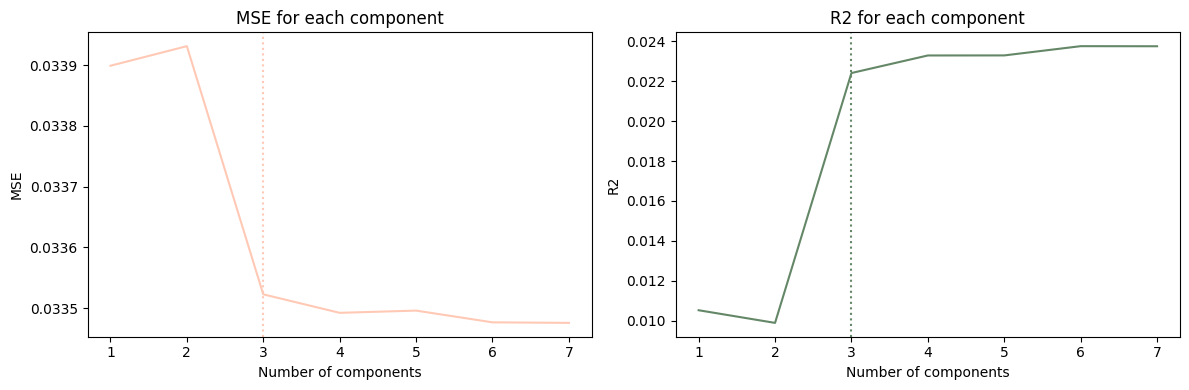

In [21]:
grid_search = GridSearchCV(pls, param_grid={'n_components': range(1, 8)}, cv=10, 
                           scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Plot the results of the grid search on separate graphs
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(range(1, 8), np.abs(grid_search.cv_results_['mean_test_neg_mean_squared_error']), color = pal[0])
axes[0].axvline(3, linestyle=':', color=pal[0])
axes[0].set_xlabel('Number of components')
axes[0].set_ylabel('MSE')
axes[0].set_title('MSE for each component')

axes[1].plot(range(1, 8), grid_search.cv_results_['mean_test_r2'], color = pal[1])
axes[1].axvline(3, linestyle=':', color=pal[1])
axes[1].set_xlabel('Number of components')
axes[1].set_ylabel('R2')
axes[1].set_title('R2 for each component')

plt.tight_layout()

### Validate predictive accuracy of PLS regression in held-out data

We now fit the PLS regression model with 3 components in the training data, and use this to predict values of $w_0^p$ in the test set. 

In [22]:
# Prediction
pls = PLSRegression(n_components=3)
pls.fit(X_train, y_train)
y_pred = pls.predict(X_test)
 
# Calculate scores
score = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R^2 score = {0}\nMSE = {1}".format(score, mse))

R^2 score = 0.04106215046813181
MSE = 0.03363925859961056


Clearly, the predictive accuracy is not superb, but it's not too bad either.

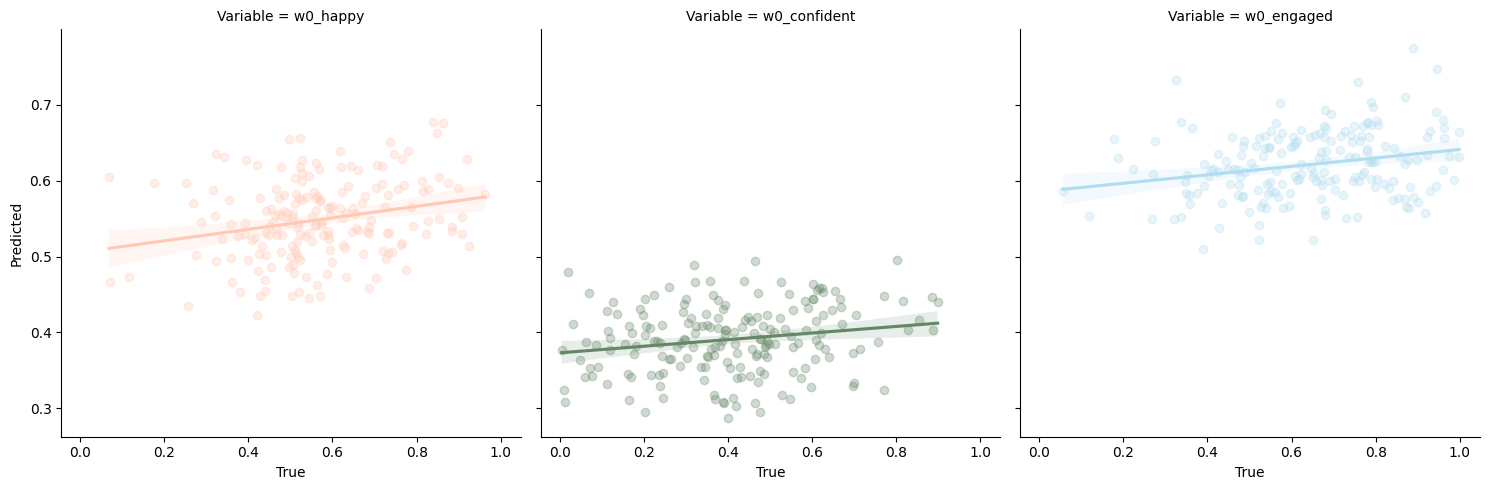

In [23]:
y_pred_df = pd.DataFrame(
    {
        'Predicted':y_pred.flatten(), 
        'True':y_test.values.flatten(), 
        'Variable': np.tile(y_test.columns, y_test.shape[0])
    }
)
sns.lmplot(
    x='True', y='Predicted', col='Variable', hue='Variable',
    data=y_pred_df, scatter_kws={'alpha': 0.3}, palette=pal
);

Lastly, we check if the predictive accuracy from the model is better than would be expected by chance.

In [24]:
import copy
permutation_pls = copy.deepcopy(pls)

n_perm = 10000
permutation_mse = np.zeros(n_perm)

for i in tqdm(range(n_perm)):
    permuted_y = y_train.copy()
    permuted_y = permuted_y.sample(frac=1)
    permutation_pls.fit(X_train, permuted_y)
    permuted_y_pred = permutation_pls.predict(X_test)
    permutation_mse[i] = mean_squared_error(y_test, permuted_y_pred)

(permutation_mse <= mse).sum()

100%|██████████| 10000/10000 [00:20<00:00, 485.25it/s]


0

No iterations where permuted MSE < our obtained MSE; i.e., $p<0.0001$.

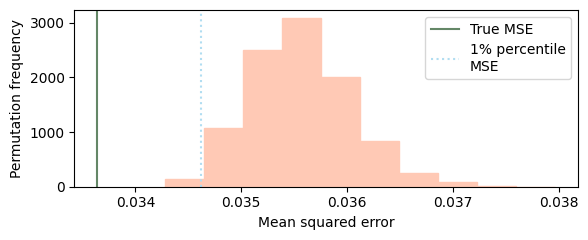

In [25]:
plt.figure(figsize=(6, 2.5), dpi=100)
plt.hist(permutation_mse, ec=pal[0], color=light_pal[0])
plt.axvline(mse, color=pal[1], label='True MSE')
plt.axvline(np.percentile(permutation_mse, 1), color=pal[2], label='1% percentile\nMSE', linestyle=':')
plt.legend()
plt.xlabel("Mean squared error")
plt.ylabel("Permutation frequency")
plt.tight_layout()

### Re-fit PLS regression model in whole dataset

Here, we fit a 3 component PLS model to all the data, and obtain bias-corrected and accelerated (BCa) bootstrapped confidence intervals.

In [26]:
def pls_regression(X_data, y_data, ncomp=3):
    pls = PLSRegression(n_components=ncomp)
    pls.fit(X_data, y_data)
    x_loadings = pls.x_loadings_
    y_loadings = pls.y_loadings_
    return np.vstack((x_loadings, y_loadings))

def pls_bootstrap(X_data, y_data, ncomp=3, nboot=1000, seed=None):
    if seed is not None:
        np.random.seed(seed)
    nobs = X_data.shape[0]
    load_boot = np.zeros((nboot, X_data.shape[1]+y_data.shape[1], ncomp))
    for i in range(nboot):
        idx = np.random.choice(range(nobs), size=nobs, replace=True)
        load_boot[i, :, :] = pls_regression(X_data.iloc[idx, :], y_data.iloc[idx, :], ncomp=ncomp)
    return load_boot

def bca_ci(obs, stat, boot_samp, alpha=0.05):
    # adapted from https://github.com/bashtage/arch/blob/main/arch/bootstrap/base.py
    q1, qu, n = stats.norm.ppf(alpha/2), stats.norm.ppf(1-alpha/2), len(obs[0])
    jk_idx = lambda i: [np.array(o)[np.r_[0:i, i+1:n]] for o in obs]

    # Acceleration factor
    jk_est = np.array([stat(*jk_idx(i)) for i in range(n)])
    u = jk_est.mean() - jk_est
    ahat = (np.sum(u**3, 0)) / (6 * (np.sum(u**2, 0) ** (3.0 / 2.0)))
    
    # Bias correction
    z0 = stats.norm.ppf((boot_samp < stat(*obs)).mean(axis=0))
    
    # Adjusted alpha levels
    a1 = stats.norm.cdf(z0 + (z0 + q1) / (1 - ahat * (z0 + q1)))
    a2 = stats.norm.cdf(z0 + (z0 + qu) / (1 - ahat * (z0 + qu)))

    # Confidence intervals
    if a1.ndim == 1:
        ci_lower = np.diagonal(np.quantile(boot_samp, a1[...], axis=0))
        ci_upper = np.diagonal(np.quantile(boot_samp, a2[...], axis=0))
    elif a1.ndim == 2:
        ci_lower, ci_upper = np.zeros_like(a1), np.zeros_like(a2)
        for i in range(a1.shape[0]):
            for j in range(a1.shape[1]):
                ci_lower[i, j] = np.quantile(boot_samp[:, i, j], a1[i, j])
                ci_upper[i, j] = np.quantile(boot_samp[:, i, j], a2[i, j])  
    else:
        raise ValueError('a1 and a2 must be 1- or 2-dimensional arrays.')

    return ci_lower, ci_upper

def ci_df(ci, obs, ncomp=3, var_type='X'):
    ci_df = pd.DataFrame(
        {
            'Loading': np.repeat(var_type, obs.shape[1] * ncomp),
            'Variable': np.repeat(obs.columns, ncomp),
            'Component': np.tile(range(1, ncomp+1), obs.shape[1]),
            'Lower CI': ci[:, :, 0].flatten(),
            'Value': ci[:, :, 1].flatten(),
            'Upper CI': ci[:, :, 2].flatten()
        }
    )
    return ci_df

def pls_conf_int(X_data, y_data, ncomp=3, nboot=1000, seed = None, alpha=0.05):
    nx, ny = X_data.shape[1], y_data.shape[1]
    load_obs = pls_regression(X_data, y_data, ncomp=ncomp)
    load_boot = pls_bootstrap(X_data, y_data, ncomp=ncomp, nboot=nboot, seed=seed)
    lower_ci, upper_ci = bca_ci([X, y], pls_regression, load_boot, alpha=alpha)
    x_ci, y_ci = np.zeros((nx, 3, 3)), np.zeros((ny, 3, 3))
    for j in range(3):
        for i in range(nx):
            x_ci[i, j, 0], x_ci[i, j, 1], x_ci[i, j, 2] = lower_ci[i, j], load_obs[i, j], upper_ci[i, j]
        for i in range(nx, nx+ny):
            y_ci[i-nx, j, 0], y_ci[i-nx, j, 1], y_ci[i-nx, j, 2] = lower_ci[i, j], load_obs[i, j], upper_ci[i, j]
    df = pd.concat([
        ci_df(x_ci, X_data, ncomp=ncomp, var_type='X'), ci_df(y_ci, y_data, ncomp=ncomp, var_type='Y')], axis=0)
    return df

pls_loading_df = pls_conf_int(X, y, ncomp=3, nboot=10000, seed=123, alpha=0.05)

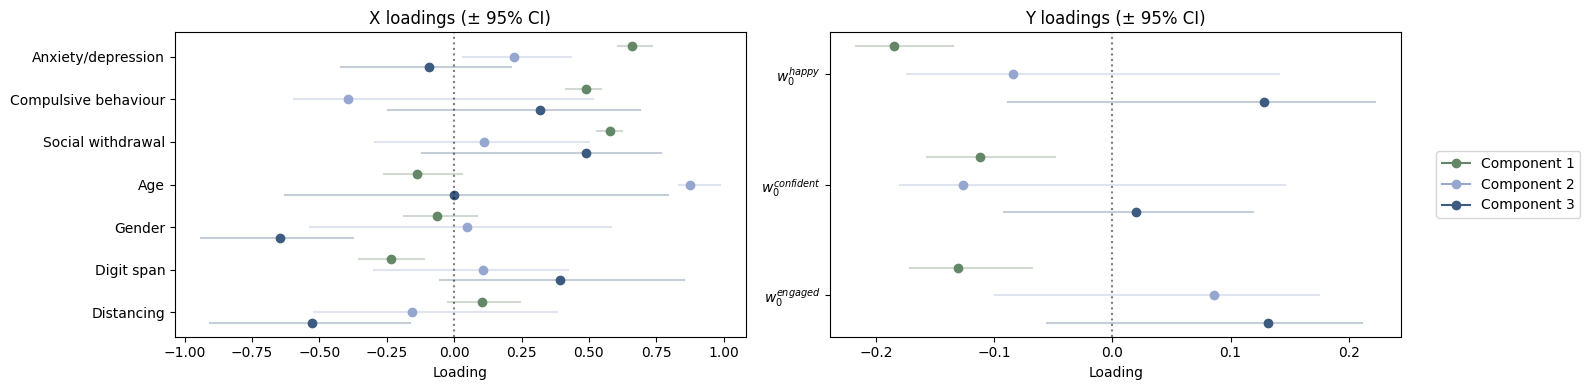

In [27]:
pretty_x_labs = {
    'AD': 'Anxiety/depression',
    'Compul': 'Compulsive behaviour',
    'SW': 'Social withdrawal',
    'age': 'Age',
    'sex': 'Gender',
    'digit_span': 'Digit span',
    'distanced': 'Distancing'
}
pretty_y_labs = {
    'w0_happy': r'$w_0^{happy}$',
    'w0_confident': r'$w_0^{confident}$',
    'w0_engaged': r'$w_0^{engaged}$'
}

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
for i, ax in enumerate(axes):
    y_shift = [-0.25, 0, 0.25]
    for j in range(3):
        for k in range([X, y][i].shape[1]):
            # plot point for value
            ax.plot(
                pls_loading_df.query(
                    f'Loading == "{["X", "Y"][i]}" and Component == {j+1} and Variable == "{[X,y][i].columns[k]}"'
                )['Value'],
                [k+y_shift[j]], marker='o', color=dark_pal[j], label=f'Component {j+1}'
            )
            # plot line for CI
            ax.plot(
                pls_loading_df.query(
                    f'Loading == "{["X", "Y"][i]}" and Component == {j+1} and Variable == "{[X,y][i].columns[k]}"'
                )[['Lower CI', 'Upper CI']].T,
                [k+y_shift[j], k+y_shift[j]], color=dark_pal[j], alpha=0.3
            )
    ax.set_xlabel('Loading')
    ax.set_ylabel('')
    ax.set_yticks(range([X, y][i].shape[1]))
    ax.set_yticklabels([X, y][i].columns.rename('Variable').map([pretty_x_labs, pretty_y_labs][i]))
    ax.axvline(0, linestyle=':', color='k', alpha=0.5)
    ax.set_title(['X loadings', 'Y loadings'][i]+' (± 95% CI)')
    ax.invert_yaxis()
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    if i==1:
        ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.tight_layout()

In [28]:
def pls_ad_reg(X_data, y_data, ncomp=3):
    pls = PLSRegression(n_components=ncomp)
    pls.fit(X_data, y_data)
    ad_diff_cb = pls.x_loadings_[0, :] - pls.x_loadings_[1, :]
    ad_diff_sw = pls.x_loadings_[0, :] - pls.x_loadings_[2, :]
    return ad_diff_cb, ad_diff_sw

def pls_ad_boot(X_data, y_data, ncomp=3, nboot=1000, seed=None):
    if seed is not None:
        np.random.seed(seed)
    nobs = X_data.shape[0]
    ad_diff_boot = np.zeros((nboot, 2, ncomp))
    for i in range(nboot):
        idx = np.random.choice(range(nobs), size=nobs, replace=True)
        ad_diff_boot[i, 0, :], ad_diff_boot[i, 1, :] = pls_ad_reg(X_data.iloc[idx, :], y_data.iloc[idx, :], ncomp=ncomp)
    return ad_diff_boot

def ad_diff_ci_df(ci, var, ncomp=3):
    ci_df = pd.DataFrame(
        {
            'Variable': np.repeat(var, ncomp),
            'Component': np.tile(range(1, ncomp+1), 1),
            'Lower CI': ci[:, 0].flatten(),
            'Value': ci[:, 1].flatten(),
            'Upper CI': ci[:, 2].flatten()
        }
    )
    return ci_df

def ad_diff_conf_int(X_data, y_data, ncomp=3, nboot=1000, seed=None, alpha=0.05):
    ad_obs = pls_ad_reg(X_data, y_data, ncomp=ncomp)
    ad_load_boot = pls_ad_boot(X_data, y_data, ncomp=ncomp, nboot=nboot, seed=seed)
    ad_lower, ad_upper = bca_ci([X, y], pls_ad_reg, ad_load_boot, alpha=alpha)
    ad_ci = np.zeros((2, 3, 3))
    for j in range(3):
        ad_ci[0, j, 0], ad_ci[0, j, 1], ad_ci[0, j, 2] = ad_lower[0][j], ad_obs[0][j], ad_upper[0][j]
        ad_ci[1, j, 0], ad_ci[1, j, 1], ad_ci[1, j, 2] = ad_lower[1][j], ad_obs[1][j], ad_upper[1][j]
    df = pd.concat([
            ad_diff_ci_df(ad_ci[0], var='AD_CB_diff', ncomp=ncomp), 
            ad_diff_ci_df(ad_ci[1], var='AD_SW_diff', ncomp=ncomp)
        ], axis=0)
    return df

ad_differences = ad_diff_conf_int(X, y, ncomp=3, nboot=10000, seed=123, alpha=0.05)

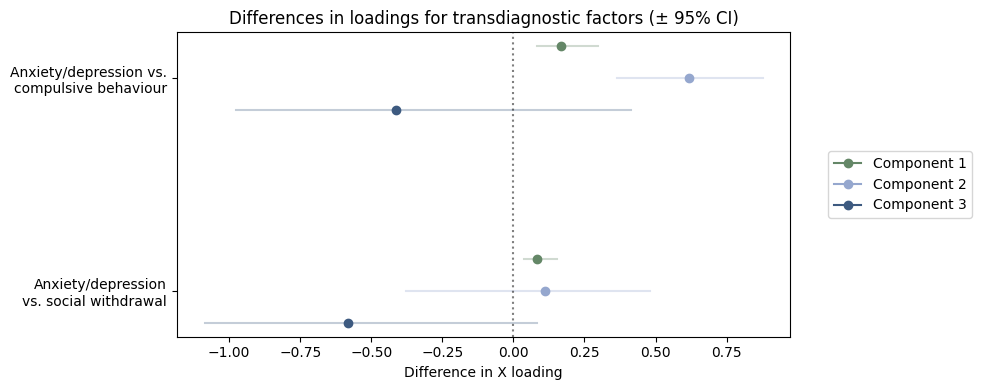

In [29]:
nms = ['AD_CB_diff', 'AD_SW_diff']
labs = [
    'Anxiety/depression vs.\ncompulsive behaviour',
    'Anxiety/depression\nvs. social withdrawal'
]

fig = plt.figure(figsize=(10, 4), dpi=100)
y_shift = [-0.15, 0, 0.15]
for j in range(3):
    for k in range(2):
        # plot point for value
        plt.plot(
            ad_differences.query(
                f'Component == {j+1} and Variable == "{nms[k]}"'
            )['Value'],
            [k+y_shift[j]], marker='o', color=dark_pal[j], label=f'Component {j+1}'
        )
        # plot line for CI
        plt.plot(
            ad_differences.query(
                f'Component == {j+1} and Variable == "{nms[k]}"'
            )[['Lower CI', 'Upper CI']].T,
            [k+y_shift[j], k+y_shift[j]], color=dark_pal[j], alpha=0.3
        )
plt.xlabel('Difference in X loading')
plt.ylabel('')
plt.yticks(range(2), labels = labs)
plt.axvline(0, linestyle=':', color='k', alpha=0.5)
plt.title('Differences in loadings for transdiagnostic factors (± 95% CI)')
plt.gca().invert_yaxis()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.tight_layout()

In [30]:
# save files
pls_loading_df.to_csv(pth_fct + "/pls_regression/pls_loading_df.csv")
ad_differences.to_csv(pth_fct + "/pls_regression/ad_differences.csv")
pd.DataFrame({
    "Components": range(1, 8), 
    "MSE": grid_search.cv_results_['mean_test_neg_mean_squared_error']
}).to_csv(pth_fct + "/pls_regression/grid_search_results.csv")

## Exploratory analysis 2: Do associations between anxiety/depression scores and model parameters differ by 'treatment' group?

Though we did have a primary "treatment" group - participants who engaged in cognitive distancing - we also asked individuals about medication usage, and a fairly large number reported being on an antidepressant (n=130 of the 935 non-excluded individuals (13.9\%); 69 distanced). This allows us to compare the effect of a psychological treatment (cognitive distancing) and a pharmacological treatment (antidepressants).

### Cognitive distancing

In [31]:
%%R
AD_dist_int <- list()

AD_dist_int$happy <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span"),
  affect_number = 1,
  interaction = "distanced", 
  extra_data = factor_scores,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

AD_dist_int$confident <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span"),
  affect_number = 2,
  interaction = "distanced",
  extra_data = factor_scores,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

AD_dist_int$engaged <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span"),
  affect_number = 3,
  interaction = "distanced", 
  extra_data = factor_scores,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.7 seconds.
Chain 2 finished in 1.6 seconds.
Chain 3 finished in 1.7 seconds.
Chain 4 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 1.8 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 4 finished in 1.5 seconds.
Chain 1 finished in 1.7 seconds.
Chain 2 finished in 1.7 seconds.
Chain 3 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 1.8 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 4 finished in 1.5 seconds.
Chain 2 finished in 1.7 seconds.
Chain 1 finished in 1.7 seconds.
Chain 3 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 1.8 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 4 finished in 1.7 seconds.
Chain 1 finished in 1.7 seconds.
Chain 2 finished in 1.7 seconds.
Chain 3 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 1.8 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 9.4 seconds.
Chain 1 finished in 9.9 seconds.
Chain 4 finished in 10.1 seconds.
Chain 3 finished in 10.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 9.9 seconds.
Total execution time: 10.4 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.6 seconds.
Chain 4 finished in 1.6 seconds.
Chain 2 finished in 1.7 seconds.
Chain 3 finished in 1.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 1.9 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.5 seconds.
Chain 2 finished in 1.6 seconds.
Chain 3 finished in 1.7 seconds.
Chain 4 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.6 seconds.
Total execution time: 1.7 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.6 seconds.
Chain 4 finished in 1.5 seconds.
Chain 1 finished in 1.7 seconds.
Chain 3 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.6 seconds.
Total execution time: 1.7 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.7 seconds.
Chain 2 finished in 1.7 seconds.
Chain 3 finished in 1.6 seconds.
Chain 4 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 1.8 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 9.7 seconds.
Chain 3 finished in 10.1 seconds.
Chain 2 finished in 10.2 seconds.
Chain 4 finished in 10.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 10.1 seconds.
Total execution time: 10.4 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.6 seconds.
Chain 3 finished in 1.6 seconds.
Chain 1 finished in 1.6 seconds.
Chain 4 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.6 seconds.
Total execution time: 1.7 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.6 seconds.
Chain 3 finished in 1.7 seconds.
Chain 4 finished in 1.7 seconds.
Chain 1 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 1.8 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 4 finished in 1.6 seconds.
Chain 1 finished in 1.7 seconds.
Chain 2 finished in 1.7 seconds.
Chain 3 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 1.8 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.6 seconds.
Chain 2 finished in 1.7 seconds.
Chain 4 finished in 1.7 seconds.
Chain 3 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 1.8 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 9.3 seconds.
Chain 3 finished in 9.6 seconds.
Chain 4 finished in 10.0 seconds.
Chain 1 finished in 10.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 9.7 seconds.
Total execution time: 10.2 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.7 seconds.
Chain 2 finished in 1.7 seconds.
Chain 3 finished in 1.7 seconds.
Chain 4 finished in 1.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 1.8 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 1.6 seconds.
Chain 4 finished in 1.7 seconds.
Chain 1 finished in 1.7 seconds.
Chain 2 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 1.8 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 1.6 seconds.
Chain 4 finished in 1.6 seconds.
Chain 1 finished in 1.7 seconds.
Chain 2 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 1.8 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.7 seconds.
Chain 3 finished in 1.7 seconds.
Chain 4 finished in 1.7 seconds.
Chain 2 finished in 1.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 1.8 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 9.3 seconds.
Chain 1 finished in 9.7 seconds.
Chain 2 finished in 9.8 seconds.
Chain 4 finished in 10.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 9.9 seconds.
Total execution time: 11.0 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.6 seconds.
Chain 2 finished in 1.7 seconds.
Chain 4 finished in 1.6 seconds.
Chain 3 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 1.8 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 1.7 seconds.
Chain 4 finished in 1.7 seconds.
Chain 1 finished in 1.7 seconds.
Chain 2 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 1.8 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 1.5 seconds.
Chain 1 finished in 1.7 seconds.
Chain 2 finished in 1.7 seconds.
Chain 4 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 1.7 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.6 seconds.
Chain 2 finished in 1.7 seconds.
Chain 3 finished in 1.6 seconds.
Chain 4 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.6 seconds.
Total execution time: 1.7 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 9.9 seconds.
Chain 3 finished in 10.0 seconds.
Chain 1 finished in 10.6 seconds.
Chain 4 finished in 10.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 10.3 seconds.
Total execution time: 10.7 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.7 seconds.
Chain 4 finished in 1.7 seconds.
Chain 2 finished in 1.7 seconds.
Chain 3 finished in 1.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 1.8 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.7 seconds.
Chain 3 finished in 1.7 seconds.
Chain 1 finished in 1.8 seconds.
Chain 4 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 1.8 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.6 seconds.
Chain 2 finished in 1.7 seconds.
Chain 3 finished in 1.7 seconds.
Chain 4 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 1.8 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.7 seconds.
Chain 4 finished in 1.6 seconds.
Chain 1 finished in 1.7 seconds.
Chain 3 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 1.8 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 9.5 seconds.
Chain 2 finished in 10.0 seconds.
Chain 4 finished in 10.1 seconds.
Chain 1 finished in 10.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 10.0 seconds.
Total execution time: 10.4 seconds.



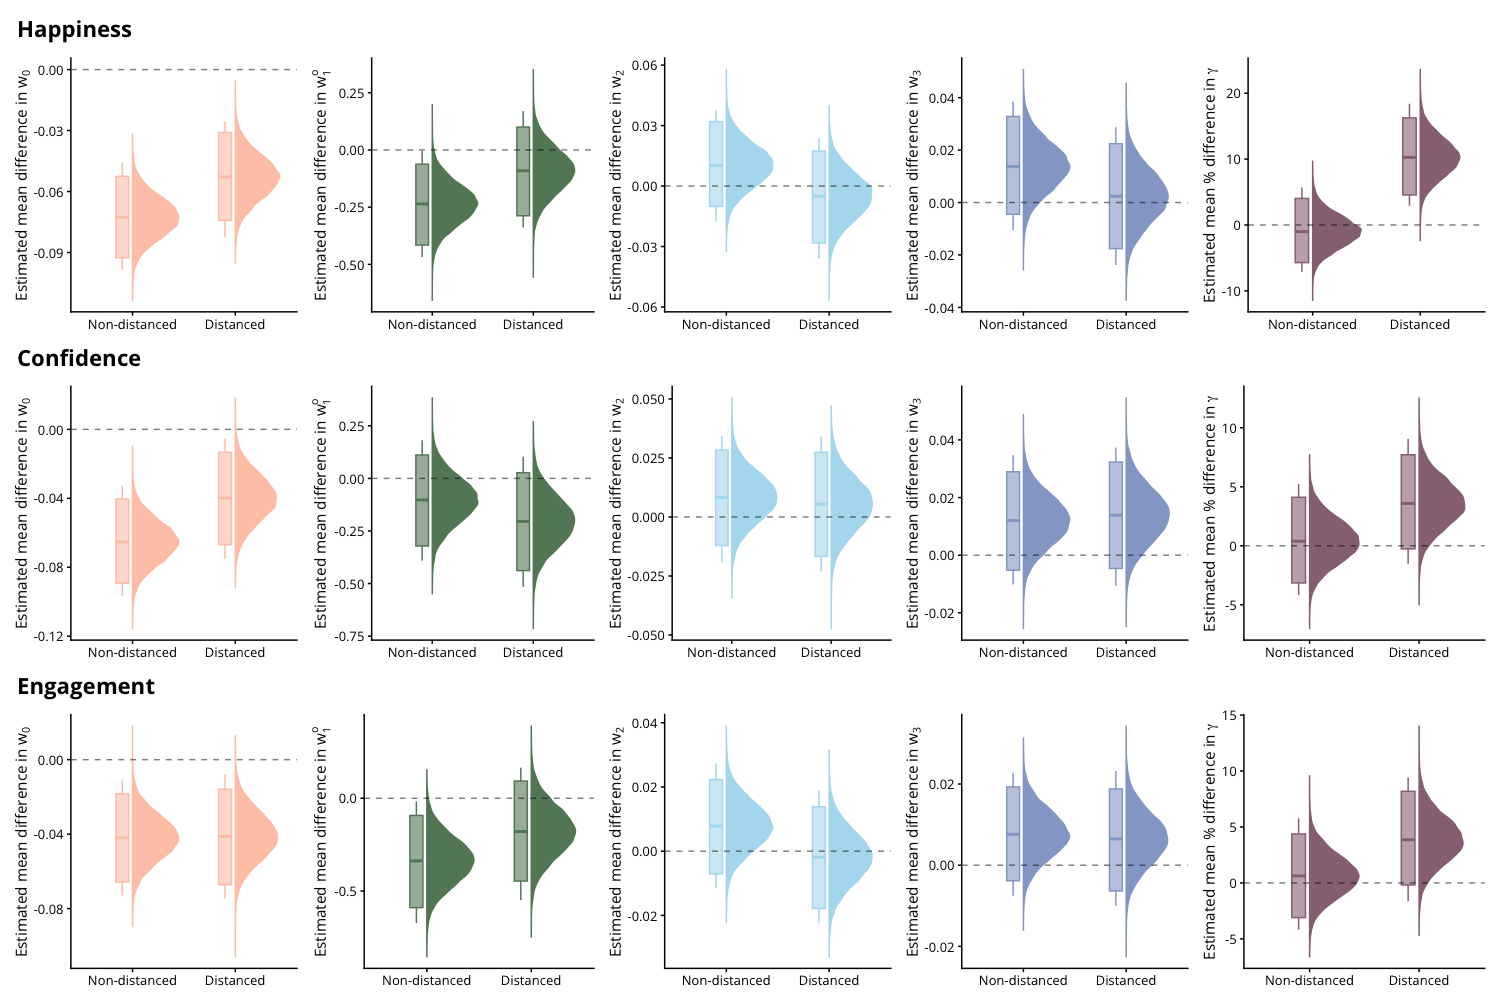

In [32]:
%%R -w 15 -h 10 --units in -r 100

AD_dist_plt_happy <- pstpipeline::plot_glm(
  AD_dist_int$happy, plot_var = "AD", grp  = "distanced", grp_labs = c("Non-distanced", "Distanced"),
  coord_flip = FALSE, box_nudge = 0.1, font = "Open Sans", pal = pal, ovrll_title = "Happiness"
)
AD_dist_plt_conf <- pstpipeline::plot_glm(
  AD_dist_int$confident, plot_var = "AD", grp  = "distanced", grp_labs = c("Non-distanced", "Distanced"),
  coord_flip = FALSE, box_nudge = 0.1, font = "Open Sans", pal = pal, ovrll_title = "Confidence"
)
AD_dist_plt_bored <- pstpipeline::plot_glm(
  AD_dist_int$engaged, plot_var = "AD", grp  = "distanced", grp_labs = c("Non-distanced", "Distanced"),
  coord_flip = FALSE, box_nudge = 0.1, font = "Open Sans", pal = pal, ovrll_title = "Engagement"
)

AD_dist_plt_happy / AD_dist_plt_conf / AD_dist_plt_bored

These results suggest that the association between increases in anxiety/depression scores and lower baseline affect did not appear to greatly differ between distanced and non-distanced individuals, though the strength of association was weaker for distancing individuals. However, the increased decay in happiness and engagement with higher anxiety/depression symptoms noted previously was not seen in the distancing group. In addition, distanced individuals scoring higher in terms of anxiety/depression tended to integrate information from more trials in their incorporation of expected value and prediction error into their effect, though the evidence for this was strong only for happiness. Very speculatively, one could suggest that distancing specifically helped those with higher anxiety/depression symptoms to integrate information from wins and losses (though the effect size is very small).

### Antidepressant usage

In [33]:
%%R
AD_antidep_int <- list()

AD_antidep_int$happy <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 1,
  interaction = "antidepressant", 
  recode_na = 0,
  extra_data = factor_scores,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

AD_antidep_int$confident <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 2,
  interaction = "antidepressant", 
  recode_na = 0,
  extra_data = factor_scores,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

AD_antidep_int$engaged <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 3,
  interaction = "antidepressant", 
  recode_na = 0,
  extra_data = factor_scores,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.8 seconds.
Chain 3 finished in 1.8 seconds.
Chain 1 finished in 1.8 seconds.
Chain 4 finished in 2.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.8 seconds.
Total execution time: 2.0 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 1.9 seconds.
Chain 4 finished in 1.9 seconds.
Chain 2 finished in 2.0 seconds.
Chain 1 finished in 2.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.0 seconds.
Total execution time: 2.2 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.9 seconds.
Chain 4 finished in 1.9 seconds.
Chain 3 finished in 2.1 seconds.
Chain 1 finished in 2.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.0 seconds.
Total execution time: 2.3 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.8 seconds.
Chain 1 finished in 1.9 seconds.
Chain 4 finished in 1.9 seconds.
Chain 3 finished in 2.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.9 seconds.
Total execution time: 2.3 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 11.9 seconds.
Chain 3 finished in 12.0 seconds.
Chain 2 finished in 12.8 seconds.
Chain 4 finished in 16.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 13.3 seconds.
Total execution time: 16.4 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.8 seconds.
Chain 2 finished in 1.8 seconds.
Chain 3 finished in 1.9 seconds.
Chain 4 finished in 1.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.9 seconds.
Total execution time: 1.9 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.8 seconds.
Chain 3 finished in 1.9 seconds.
Chain 4 finished in 1.9 seconds.
Chain 1 finished in 2.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.9 seconds.
Total execution time: 2.0 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.8 seconds.
Chain 3 finished in 1.8 seconds.
Chain 2 finished in 2.0 seconds.
Chain 4 finished in 1.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.9 seconds.
Total execution time: 2.0 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.8 seconds.
Chain 3 finished in 1.8 seconds.
Chain 2 finished in 1.9 seconds.
Chain 4 finished in 1.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.9 seconds.
Total execution time: 2.0 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 11.5 seconds.
Chain 3 finished in 12.6 seconds.
Chain 4 finished in 12.6 seconds.
Chain 1 finished in 12.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 12.4 seconds.
Total execution time: 13.0 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 1.8 seconds.
Chain 1 finished in 1.9 seconds.
Chain 2 finished in 1.8 seconds.
Chain 4 finished in 2.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.9 seconds.
Total execution time: 2.4 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.8 seconds.
Chain 3 finished in 1.8 seconds.
Chain 4 finished in 1.9 seconds.
Chain 1 finished in 2.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.0 seconds.
Total execution time: 2.4 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.8 seconds.
Chain 1 finished in 1.9 seconds.
Chain 3 finished in 2.1 seconds.
Chain 4 finished in 2.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.0 seconds.
Total execution time: 2.4 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.8 seconds.
Chain 2 finished in 1.8 seconds.
Chain 3 finished in 1.9 seconds.
Chain 4 finished in 1.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.9 seconds.
Total execution time: 2.0 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 4 finished in 11.8 seconds.
Chain 3 finished in 12.3 seconds.
Chain 1 finished in 12.5 seconds.
Chain 2 finished in 14.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 12.8 seconds.
Total execution time: 14.7 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.8 seconds.
Chain 4 finished in 1.8 seconds.
Chain 2 finished in 2.1 seconds.
Chain 3 finished in 2.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.9 seconds.
Total execution time: 2.2 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.9 seconds.
Chain 2 finished in 1.9 seconds.
Chain 4 finished in 2.0 seconds.
Chain 3 finished in 2.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.0 seconds.
Total execution time: 2.5 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.8 seconds.
Chain 3 finished in 1.9 seconds.
Chain 2 finished in 2.0 seconds.
Chain 4 finished in 1.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.9 seconds.
Total execution time: 2.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.9 seconds.
Chain 3 finished in 1.9 seconds.
Chain 4 finished in 1.9 seconds.
Chain 2 finished in 2.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.9 seconds.
Total execution time: 2.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 4 finished in 11.6 seconds.
Chain 2 finished in 11.8 seconds.
Chain 3 finished in 12.3 seconds.
Chain 1 finished in 12.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 12.0 seconds.
Total execution time: 12.4 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.8 seconds.
Chain 2 finished in 1.9 seconds.
Chain 3 finished in 1.9 seconds.
Chain 4 finished in 1.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.9 seconds.
Total execution time: 1.9 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.9 seconds.
Chain 2 finished in 1.8 seconds.
Chain 3 finished in 1.8 seconds.
Chain 4 finished in 2.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.9 seconds.
Total execution time: 2.2 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.8 seconds.
Chain 3 finished in 1.8 seconds.
Chain 4 finished in 2.0 seconds.
Chain 2 finished in 2.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.9 seconds.
Total execution time: 2.2 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.8 seconds.
Chain 3 finished in 1.9 seconds.
Chain 2 finished in 2.0 seconds.
Chain 4 finished in 2.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.9 seconds.
Total execution time: 2.2 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 11.5 seconds.
Chain 3 finished in 11.7 seconds.
Chain 1 finished in 12.0 seconds.
Chain 4 finished in 13.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 12.1 seconds.
Total execution time: 13.4 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.9 seconds.
Chain 4 finished in 1.8 seconds.
Chain 2 finished in 2.0 seconds.
Chain 3 finished in 2.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.9 seconds.
Total execution time: 2.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.9 seconds.
Chain 3 finished in 1.9 seconds.
Chain 4 finished in 1.9 seconds.
Chain 2 finished in 2.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.9 seconds.
Total execution time: 2.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.8 seconds.
Chain 2 finished in 1.9 seconds.
Chain 4 finished in 1.8 seconds.
Chain 3 finished in 2.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.9 seconds.
Total execution time: 2.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.7 seconds.
Chain 1 finished in 1.9 seconds.
Chain 4 finished in 2.0 seconds.
Chain 3 finished in 2.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.0 seconds.
Total execution time: 2.4 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 10.9 seconds.
Chain 2 finished in 11.7 seconds.
Chain 3 finished in 12.3 seconds.
Chain 4 finished in 12.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 11.8 seconds.
Total execution time: 12.5 seconds.



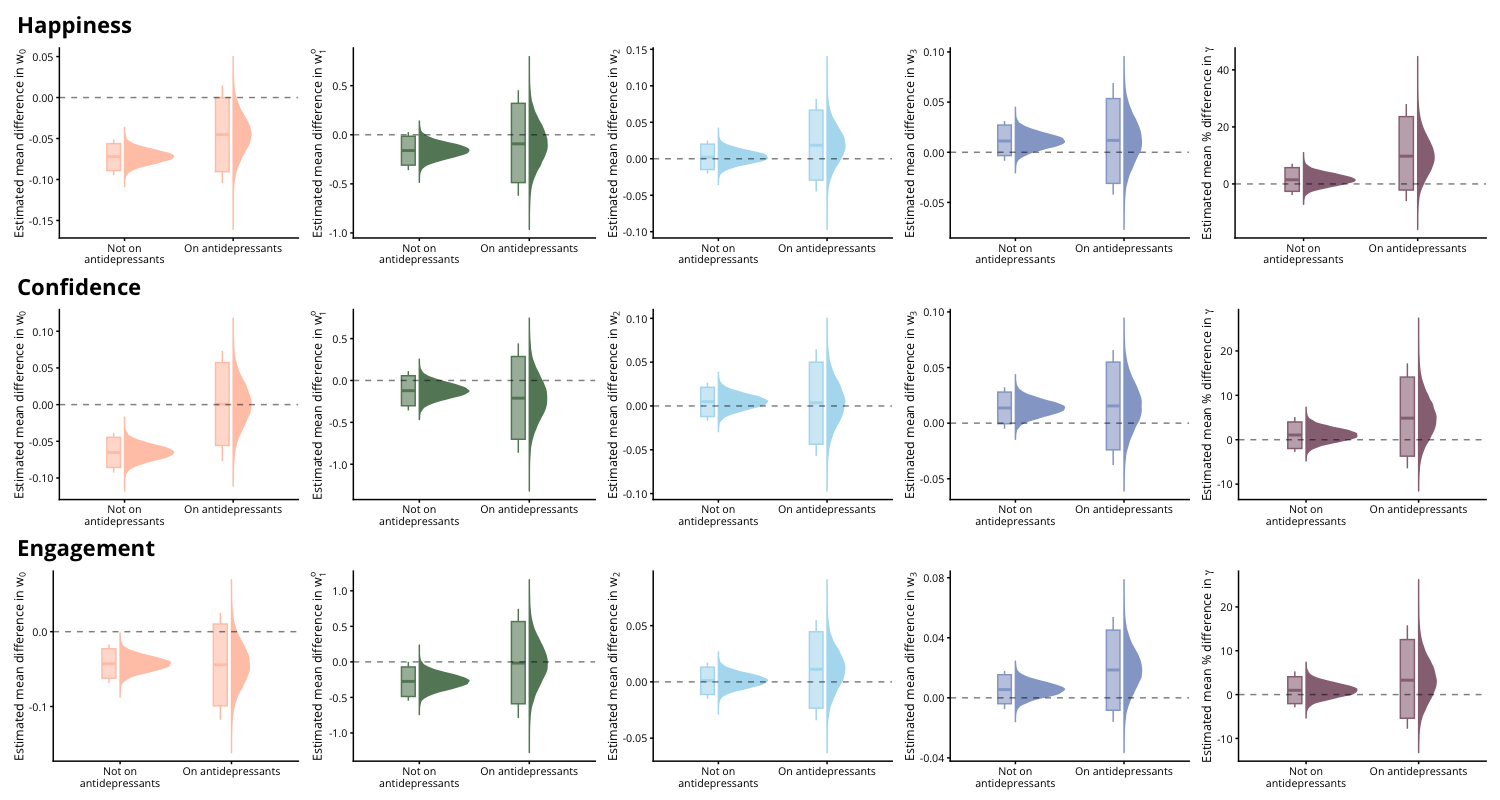

In [34]:
%%R -w 15 -h 8 --units in -r 100

AD_antidep_plt_happy <- pstpipeline::plot_glm(
  AD_antidep_int$happy, plot_var = "AD", grp = "antidepressant", grp_labs = c("Not on\nantidepressants", "On antidepressants"),
  coord_flip = FALSE, box_nudge = 0.1, font_size = 9, font = "Open Sans", pal = pal, ovrll_title = "Happiness"
)
AD_antidep_plt_conf <- pstpipeline::plot_glm(
  AD_antidep_int$confident, plot_var = "AD", grp = "antidepressant", grp_labs = c("Not on\nantidepressants", "On antidepressants"),
  coord_flip = FALSE, box_nudge = 0.1, font_size = 9, font = "Open Sans", pal = pal, ovrll_title = "Confidence"
)
AD_antidep_plt_bored <- pstpipeline::plot_glm(
  AD_antidep_int$engaged, plot_var = "AD", grp = "antidepressant", grp_labs = c("Not on\nantidepressants", "On antidepressants"),
  coord_flip = FALSE, box_nudge = 0.1, font_size = 9, font = "Open Sans", pal = pal, ovrll_title = "Engagement"
)

AD_antidep_plt_happy / AD_antidep_plt_conf / AD_antidep_plt_bored

Interestingly, we find that the evidence for a negative association between baseline affect and anxiety/depression scores greatly diminished in those currently taking an antidepressant. In addition, we see evidence of a similar effect on the decay in affect over time to cognitive distancing, whereby increases in anxiety/depression scores are not associated with increased time-related decay in happiness and engagement in those on antidepressants.

In [35]:
%%R
explore_AD_grp <- list()
explore_AD_grp$AD_dist_int <- AD_dist_int
explore_AD_grp$AD_antidep_int <- AD_antidep_int

saveRDS(explore_AD_grp, "outputs/cmdstan/affect_2a/outcome_glms/exploratory_AD_interaction_models.RDS")

## Exploratory analysis 3: Associations between model parameters and self-reported fatigue

One final point of interest is whether self-reported fatigue, which was reported between 0 and 100 at the end of each block in response to the question *"How **fatigued** do you feel compared to the beginning of the block?"*, related to the model parameters. Here we look at two quantities - the mean post-block fatigue score, which should correlate with $w^b_1$, and the per-block change in this post-block fatigue score (i.e., coefficient from regression of fatigue score on trial block), which may perhaps relate more to the overall decay in affect ($w^o_1$).

In [36]:
%%R
fatigue <- dplyr::bind_rows(
    all_res_split$non_distanced$training, 
    all_res_split$distanced$training
  ) |>
  dplyr::filter(!is.na(fatigue_response)) |>
  dplyr::mutate(fatigue_response = fatigue_response / 10) |>
    # so now unit increase = 10%
  dplyr::select(subjID, trial_block, fatigue_response)

fatigue_data <- data.table::rbindlist(
  lapply(
  unique(fatigue$subjID),
  function (s) {
    coefs <- lm(fatigue_response ~ trial_block, data = subset(fatigue, subjID == s))$coefficients
    return(tibble::tibble(
      "subjID" = s,
      "mu_post_block_fatigue" = mean(subset(fatigue, subjID == s)$fatigue_response), 
      "delta_post_block_fatigue" = ifelse(is.na(coefs[[2]]), 0, coefs[[2]])
    ))
  }
))

### Association between mean post-block fatigue and model parameters

In [37]:
%%R
post_block_fatigue <- list()

post_block_fatigue$happy <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "mu_post_block_fatigue",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 1,
  extra_data = fatigue_data,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

post_block_fatigue$confident <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "mu_post_block_fatigue",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 2,
  extra_data = fatigue_data,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

post_block_fatigue$engaged <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "mu_post_block_fatigue",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 3,
  extra_data = fatigue_data,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Compiling Stan program...



Running MCMC with 4 parallel chains...|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.0 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 3.6 seconds.
Chain 3 finished in 3.6 seconds.
Chain 4 finished in 3.7 seconds.
Chain 1 finished in 4.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.8 seconds.
Total execution time: 4.3 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.0 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 1 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 3.5 seconds.
Chain 3 finished in 3.5 seconds.
Chain 1 finished in 3.7 seconds.
Chain 4 finished in 3.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.6 seconds.
Total execution time: 3.7 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.5 seconds.
Chain 2 finished in 3.5 seconds.
Chain 3 finished in 3.5 seconds.
Chain 4 finished in 3.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.6 seconds.
Total execution time: 3.7 seconds.



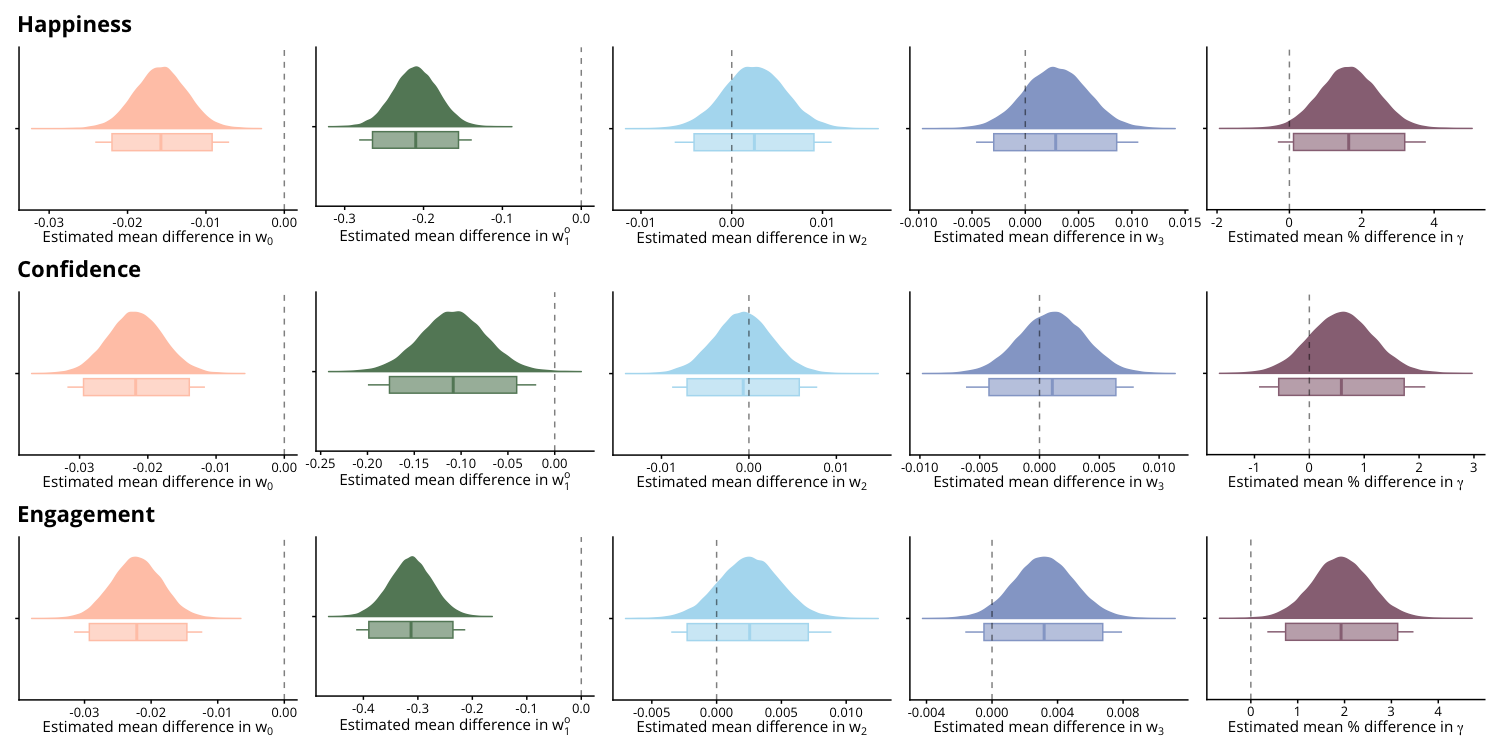

In [38]:
%%R -w 15 -h 7.5 --units in -r 100

fatigue_plt_happy <- pstpipeline::plot_glm(
  post_block_fatigue$happy, plot_var = "mu_post_block_fatigue", font = "Open Sans", pal = pal, ovrll_title = "Happiness"
)
fatigue_plt_conf <- pstpipeline::plot_glm(
  post_block_fatigue$confident, plot_var = "mu_post_block_fatigue", font = "Open Sans", pal = pal, ovrll_title = "Confidence"
)
fatigue_plt_bored <- pstpipeline::plot_glm(
  post_block_fatigue$engaged, plot_var = "mu_post_block_fatigue", font = "Open Sans", pal = pal, ovrll_title = "Engagement"
)

fatigue_plt_happy / fatigue_plt_conf / fatigue_plt_bored

Perhaps unsurprisingly, self-reported post-block fatigue is strongly negatively associated with $w^o_1$ across all three affect ratings. In addition, it is also strongly associated with baseline ratings for all three affect adjectives, though it should be noted there is limited evidence of a positive association between any of the factor scores and post-block fatigue ($r$=0.05-0.11), the effects of which on $w_0$ appear independent of fatigue.

### Association between *change* in post-block fatigue ratings and model parameters

Note that we also control for mean overall fatigue ratings here, as clearly baseline fatigue and interpretations of the scale will differ.

In [39]:
%%R
post_block_fatigue_change <- list()

post_block_fatigue_change$happy <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "delta_post_block_fatigue",
  covariates = c("age", "sex", "digit_span", "distanced", 
                 "mu_post_block_fatigue"),
  affect_number = 1,
  extra_data = fatigue_data,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

post_block_fatigue_change$confident <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "delta_post_block_fatigue",
  covariates = c("age", "sex", "digit_span", "distanced", 
                 "mu_post_block_fatigue"),
  affect_number = 2,
  extra_data = fatigue_data,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

post_block_fatigue_change$engaged <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "delta_post_block_fatigue",
  covariates = c("age", "sex", "digit_span", "distanced", 
                 "mu_post_block_fatigue"),
  affect_number = 3,
  extra_data = fatigue_data,
  bsl_trnsfm = function(x) plogis(x),
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.
Chain 1 finished in 1.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.2 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 3.7 seconds.
Chain 3 finished in 3.6 seconds.
Chain 4 finished in 3.7 seconds.
Chain 1 finished in 4.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.8 seconds.
Total execution time: 4.3 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 4 finished in 3.6 seconds.
Chain 1 finished in 3.7 seconds.
Chain 3 finished in 3.7 seconds.
Chain 2 finished in 4.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.8 seconds.
Total execution time: 4.5 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 1 finished in 1.0 seconds.
Chain 4 finished in 1.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.1 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.7 seconds.
Chain 3 finished in 3.8 seconds.
Chain 2 finished in 4.0 seconds.
Chain 4 finished in 4.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.9 seconds.
Total execution time: 4.1 seconds.



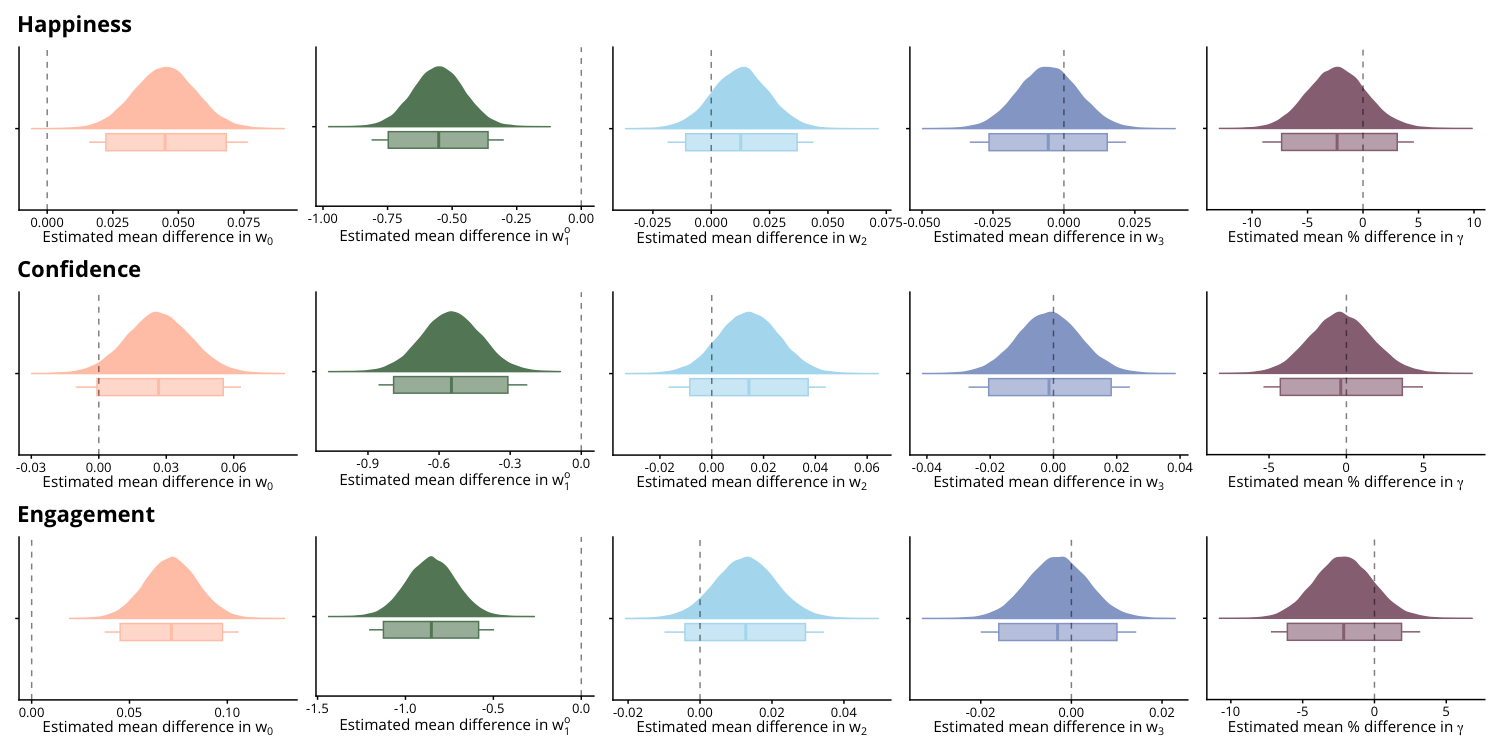

In [40]:
%%R -w 15 -h 7.5 --units in -r 100

fatigue_change_plt_happy <- pstpipeline::plot_glm(
  post_block_fatigue_change$happy, plot_var = "delta_post_block_fatigue", font = "Open Sans", pal = pal, ovrll_title = "Happiness"
)
fatigue_change_plt_conf <- pstpipeline::plot_glm(
  post_block_fatigue_change$confident, plot_var = "delta_post_block_fatigue", font = "Open Sans", pal = pal, ovrll_title = "Confidence"
)
fatigue_change_plt_bored <- pstpipeline::plot_glm(
  post_block_fatigue_change$engaged, plot_var = "delta_post_block_fatigue", font = "Open Sans", pal = pal, ovrll_title = "Engagement"
)

fatigue_change_plt_happy / fatigue_change_plt_conf / fatigue_change_plt_bored

Indeed, as suspected, there is a negative assocaition between change in post-block fatigue (i.e., where positive coefficients = more tired at the end of the block) and $w^o_1$. In addition, interestingly, increased declines were associated with higher baseline happiness and engagement, which may perhaps represent an effect of motivation - participants who were more motivated and engaged towards the beginning of the task also exerted more effort throughout the task, resulting in greater overall increases in fatigue and decreases in affect.

In [41]:
%%R
explore_fatigue <- list()
explore_fatigue$post_block_fatigue <- post_block_fatigue
explore_fatigue$post_block_fatigue_change <- post_block_fatigue_change

saveRDS(explore_fatigue, "outputs/cmdstan/affect_2a/outcome_glms/exploratory_fatigue_models.RDS")

## Exploratory analysis 4: What is the effect of distancing or antidepressant use on trial-to-trial *changes* in affect ratings?

For this final analysis, we explore the effect of the treatments on trial-to-trial changes in affect ratings (of each type), by conditioning on the previous rating, and considering only the effect of the current trial EV and PE (we also control for the time elapsed in between ratings). We compare three further models, all of which include the effect of intervening time ($w^p_{1i}$) and assume a dual learning rate $Q$-learning model for choices. The simplest model replaces $w^p_0$ with the previous rating (making the strong assumption that the previous rating has the same weight=1 for all participants and adjectives); the second model allows for this weighting to vary (we denote this weight $w^p_{1c}$), and the final model also adds back the baseline parameter $w^p_0$.

In [42]:
%%R
cond_model_3wt_vb <- pstpipeline::fit_learning_model(
    all_res, model = "2a", exp_part = "training", affect = TRUE, 
    affect_sfx = "cond_3wt", vb = TRUE, tol_rel_obj = 0.005, iter = 15000,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_2a/all/model_fits/cond_model/model_comp/m1"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 0.441087 seconds 
1000 transitions using 10 leapfrog steps per transition would take 4410.87 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Success! Found best value [eta = 1] earlier than expected. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100  -34034514876941.199             1.000            1.000 
   200  -268499725040421.281             0.937            1.000 
   300  -8339246670145.624         

In [43]:
%%R
cond_model_4wt_vb <- pstpipeline::fit_learning_model(
    all_res, model = "2a", exp_part = "training", affect = TRUE, 
    affect_sfx = "cond_4wt", vb = TRUE, tol_rel_obj = 0.005, iter = 15000,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_2a/all/model_fits/cond_model/model_comp/m2"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 0.457339 seconds 
1000 transitions using 10 leapfrog steps per transition would take 4573.39 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Success! Found best value [eta = 1] earlier than expected. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100  -10873875402440421376.000             1.000            1.000 
   200  -2658710779189017.000          2044.953         4088.905 
   300  -342982201237.885   

In [44]:
%%R
cond_model_5wt_vb <- pstpipeline::fit_learning_model(
    all_res, model = "2a", exp_part = "training", affect = TRUE, 
    affect_sfx = "cond_5wt", vb = TRUE, tol_rel_obj = 0.005, iter = 15000,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_2a/all/model_fits/cond_model/model_comp/m3"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 0.617544 seconds 
1000 transitions using 10 leapfrog steps per transition would take 6175.44 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Iteration: 250 / 250 [100%]  (Adaptation) 
Success! Found best value [eta = 0.1]. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100  -3507409043310645346304.000             1.000            1.000 
   200  -4006947762099.419     437665930.722    875331860.445 
   300

In [45]:
%%R
loo_m1 <- readRDS("outputs/cmdstan/affect_2a/all/model_fits/cond_model/model_comp/m1/fit_pst_training_2a_vb_loo_obj.RDS")
loo_m2 <- readRDS("outputs/cmdstan/affect_2a/all/model_fits/cond_model/model_comp/m2/fit_pst_training_2a_vb_loo_obj.RDS")
loo_m3 <- readRDS("outputs/cmdstan/affect_2a/all/model_fits/cond_model/model_comp/m3/fit_pst_training_2a_vb_loo_obj.RDS")

cond_mod_comp <- loo::loo_compare(loo_m1, loo_m2, loo_m3)

In [46]:
%%R
print(cond_mod_comp, digits = 1, simplify = FALSE)

       elpd_diff se_diff   elpd_loo  se_elpd_loo p_loo     se_p_loo  looic     se_looic 
model3       0.0       0.0  242693.7    7567.9      7505.0     244.3 -485387.4   15135.7
model2  -24348.9    1378.5  218344.7    7549.9      4409.4     184.2 -436689.5   15099.8
model1  -53601.4    1866.6  189092.3    6796.3      3724.9     139.7 -378184.6   13592.7


We find that the model including five weights (i.e., $w^p_0$, $w^p_1c$, $w^p_1i$, $w^p_2$, $w^p_3$) is the best-fitting model.

### Check fits

In [47]:
%%R
pth <- "outputs/cmdstan/affect_2a/all/model_fits/cond_model/model_comp/m3/"
draws_ls_cm   <- posterior::as_draws_df(
    readRDS(paste0(pth, "fit_pst_training_2a_vb_draws_list.RDS"))
)
raw_df_cm <- readRDS(paste0(pth, "fit_pst_training_2a_vb_raw_df.RDS"))
summary_df_cm <- readRDS(paste0(pth,"fit_pst_training_2a_vb_summary.RDS"))
pars_cm <- pstpipeline::make_par_df(raw_df_cm, summary_df_cm)

pars_cm |>
    dplyr::group_by(parameter, adj) |>
    dplyr::filter(subjID %in% unique(pars$subjID)) |>
    dplyr::summarise(
        n = dplyr::n(), 
        median = median(posterior_mean, na.rm = TRUE), 
        mean = mean(posterior_mean, na.rm = TRUE),
        sd = sd(posterior_mean),
        min = min(posterior_mean, na.rm = TRUE),
        max = max(posterior_mean, na.rm = TRUE),
        .groups = "keep"
    )

# A tibble: 18 × 8
# Groups:   parameter, adj [18]
   parameter adj           n   median     mean      sd        min    max
   <chr>     <chr>     <int>    <dbl>    <dbl>   <dbl>      <dbl>  <dbl>
 1 alpha_neg <NA>        935  0.00365  0.0459  0.102    0.0000537 0.896 
 2 alpha_pos <NA>        935  0.106    0.109   0.0371   0.0367    0.258 
 3 beta      <NA>        935  2.05     2.15    1.29     0.184     6.95  
 4 w0        confident   935 -1.24    -1.33    0.836   -4.71      0.888 
 5 w0        engaged     935 -1.24    -1.37    0.858   -4.16      1.29  
 6 w0        happy       935 -1.01    -1.12    0.725   -4.17      1.36  
 7 w1_c      confident   935  1.75     1.94    0.908    0.137     5.16  
 8 w1_c      engaged     935  2.90     3.04    1.38    -0.352     7.54  
 9 w1_c      happy       935  2.15     2.36    1.15    -0.184     6.49  
10 w1_i      confident   935 -0.00217 -0.00200 0.0301  -0.125     0.108 
11 w1_i      engaged     935  0.0119   0.0118  0.00300 -0.00895   0.0371


In [48]:
%%R
# extract posterior predictions
fits <- list()
for (adj in c("happy", "confident", "engaged")) {
    fits[[adj]] <- pstpipeline::get_affect_ppc(draws_ls_cm, raw_df_cm, adj = adj)
}
saveRDS(fits, "outputs/cmdstan/affect_2a/fit_dfs_cond_5wt_vb.RDS")

  |==============================================================================================================| 100%

In [49]:
%%R
fits_all <- 
    dplyr::bind_rows(
        fits$happy$fit_df |> dplyr::mutate(adj = "happy"),
        fits$confident$fit_df |> dplyr::mutate(adj = "confident"),
        fits$engaged$fit_df |> dplyr::mutate(adj = "engaged")
    )
    
# library(rlang, quietly = TRUE, warn.conflicts = FALSE)
stats <- list()
for (stat in c("R2", "MAE", "RMSE")) {
    s <- rlang::sym(stat)
    stats[[stat]] <- fits_all |> 
        dplyr::group_by(adj) |> 
        dplyr::summarise(
            n = dplyr::n(), 
            NAs = sum(is.na(!!s)), 
            median = median(!!s, na.rm = TRUE), 
            mean = mean(!!s, na.rm = TRUE),
            sd = sd(!!s, na.rm = TRUE),
            min = min(!!s, na.rm = TRUE),
            max = max(!!s, na.rm = TRUE),
            .groups = "keep"
        )
}
stats

$R2
# A tibble: 3 × 8
# Groups:   adj [3]
  adj           n   NAs median  mean    sd        min   max
  <chr>     <int> <int>  <dbl> <dbl> <dbl>      <dbl> <dbl>
1 confident   935     3  0.421 0.420 0.226 0.000328   0.934
2 engaged     935     3  0.452 0.452 0.270 0.00000366 0.969
3 happy       935     2  0.406 0.414 0.237 0.000130   0.976

$MAE


# A tibble: 3 × 8
# Groups:   adj [3]
  adj           n   NAs median  mean    sd     min   max
  <chr>     <int> <int>  <dbl> <dbl> <dbl>   <dbl> <dbl>
1 confident   935     0   7.18  7.84  3.74 0.636    30.2
2 engaged     935     0   6.36  7.08  3.68 0.00951  29.8
3 happy       935     0   6.27  6.91  3.59 0.0333   30.4

$RMSE
# A tibble: 3 × 8
# Groups:   adj [3]
  adj           n   NAs median  mean    sd     min   max
  <chr>     <int> <int>  <dbl> <dbl> <dbl>   <dbl> <dbl>
1 confident   935     0   9.42 10.2   4.55 0.643    35.3
2 engaged     935     0   8.44  9.29  4.51 0.00974  33.9
3 happy       935     0   8.16  8.95  4.35 0.0335   34.3



Notably, the predictive accuracy of this model is better than the winning non-conditional model, but not substantially.

### Effect of cognitive distancing on trial-to-trial changes in affect

In [50]:
%%R
dist_cond_models <- list()
dist_cond_models$happy <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_cm),
  raw_df = list(raw_df_cm),
  var_of_interest = "distanced",
  covariates = c("age", "sex", "digit_span"),
  affect_number = 1,
  iter_warmup = 2000, iter_sampling = 10000
)

dist_cond_models$confident <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_cm),
  raw_df = list(raw_df_cm),
  var_of_interest = "distanced",
  covariates = c("age", "sex", "digit_span"),
  affect_number = 2,
  iter_warmup = 2000, iter_sampling = 10000
)

dist_cond_models$engaged <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_cm),
  raw_df = list(raw_df_cm),
  var_of_interest = "distanced",
  covariates = c("age", "sex", "digit_span"),
  affect_number = 3,
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 0.9 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 0.9 seconds.
Chain 2 finished in 1.0 seconds.
Chain 4 finished in 0.9 seconds.
Chain 3 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.9 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 6.5 seconds.
Chain 1 finished in 6.9 seconds.
Chain 3 finished in 7.0 seconds.
Chain 4 finished in 7.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 6.9 seconds.
Total execution time: 7.4 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.0 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.1 seconds.
Chain 2 finished in 1.2 seconds.
Chain 3 finished in 1.2 seconds.
Chain 4 finished in 1.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.1 seconds.
Total execution time: 1.2 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 0.9 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.0 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 4 finished in 3.9 seconds.
Chain 2 finished in 4.3 seconds.
Chain 3 finished in 4.3 seconds.
Chain 1 finished in 4.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 4.2 seconds.
Total execution time: 4.5 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.1 seconds.
Chain 2 finished in 1.1 seconds.
Chain 3 finished in 1.1 seconds.
Chain 4 finished in 1.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.1 seconds.
Total execution time: 1.2 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



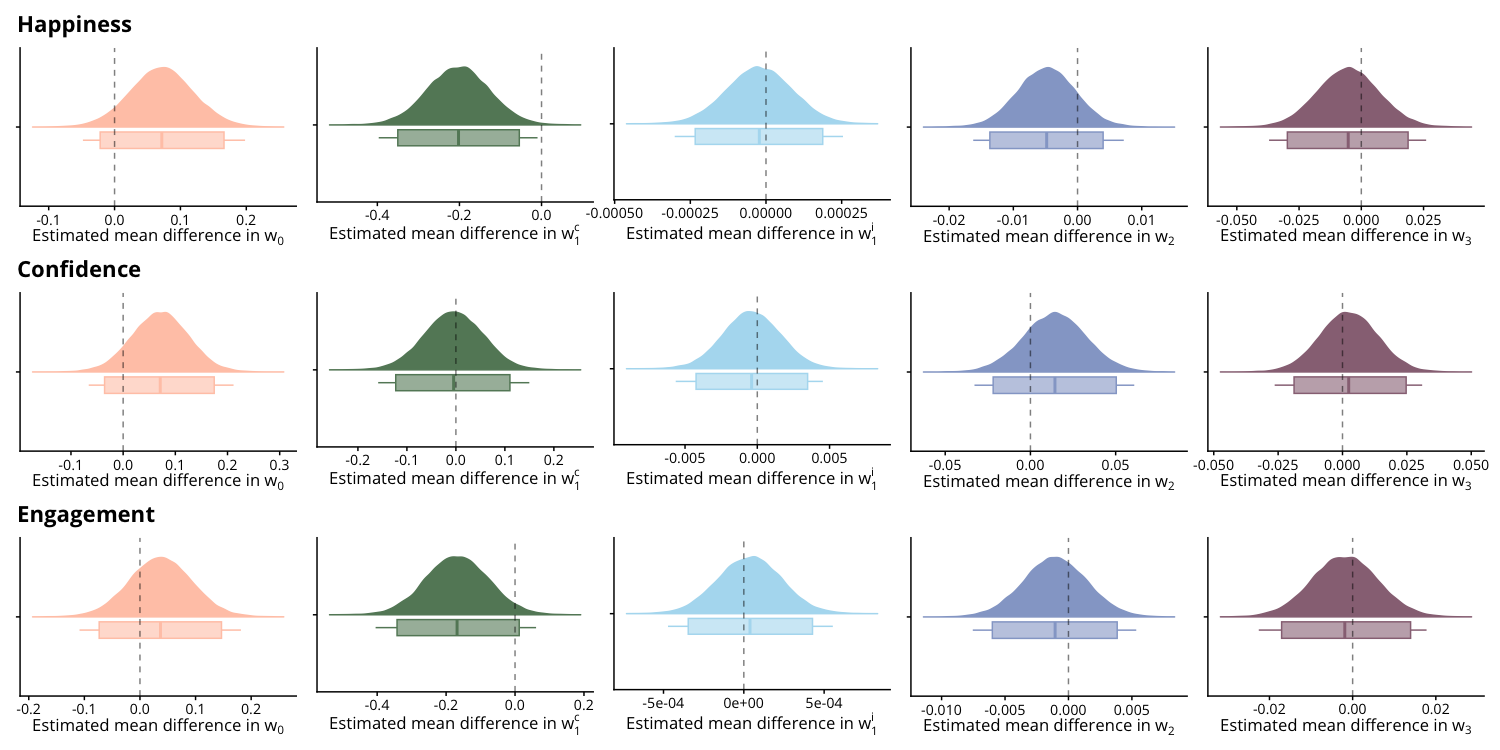

In [51]:
%%R -w 15 -h 7.5 --units in -r 100

dist_plt_happy <- pstpipeline::plot_glm(
  dist_cond_models$happy, plot_var = "distanced", font = "Open Sans", 
  font_size = 12, pal = pal, ovrll_title = "Happiness"
)
dist_plt_conf <- pstpipeline::plot_glm(
  dist_cond_models$confident, plot_var = "distanced", font = "Open Sans", 
  font_size = 12, pal = pal, ovrll_title = "Confidence"
)
dist_plt_bored <- pstpipeline::plot_glm(
  dist_cond_models$engaged, plot_var = "distanced", font = "Open Sans",
  font_size = 12, pal = pal, ovrll_title = "Engagement"
)

dist_plt_happy / dist_plt_conf / dist_plt_bored

These results indicate that participants practicing cognitive distancing placed less weight on their previous affect rating when computing the subsequent happiness (and to an extent engagement) rating.

### Effect of antidepressant use on trial-to-trial changes in affect

Given that this treatment was not randomised, we additionally consider whether observed associations were independent of anxiety/depression symptom scores.

In [52]:
%%R
antidep_cond_models <- list()
antidep_cond_models$happy <- list()
antidep_cond_models$confident <- list()
antidep_cond_models$engaged <- list()

# happiness

antidep_cond_models$happy$no_AD <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_cm),
  raw_df = list(raw_df_cm),
  var_of_interest = "antidepressant",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 1, recode_na = 0,
  iter_warmup = 2000, iter_sampling = 10000
)
antidep_cond_models$happy$AD <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_cm),
  raw_df = list(raw_df_cm),
  var_of_interest = "antidepressant",
  covariates = c("age", "sex", "digit_span", "distanced", "AD"),
  affect_number = 1, recode_na = 0,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

# confidence

antidep_cond_models$confident$no_AD <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_cm),
  raw_df = list(raw_df_cm),
  var_of_interest = "antidepressant",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 2, recode_na = 0,
  iter_warmup = 2000, iter_sampling = 10000
)
antidep_cond_models$confident$AD <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_cm),
  raw_df = list(raw_df_cm),
  var_of_interest = "antidepressant",
  covariates = c("age", "sex", "digit_span", "distanced", "AD"),
  affect_number = 2, recode_na = 0,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

# engagement

antidep_cond_models$engaged$no_AD <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_cm),
  raw_df = list(raw_df_cm),
  var_of_interest = "antidepressant",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 3, recode_na = 0,
  iter_warmup = 2000, iter_sampling = 10000
)
antidep_cond_models$engaged$AD <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_cm),
  raw_df = list(raw_df_cm),
  var_of_interest = "antidepressant",
  covariates = c("age", "sex", "digit_span", "distanced", "AD"),
  affect_number = 3, recode_na = 0,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 6.5 seconds.
Chain 3 finished in 6.9 seconds.
Chain 2 finished in 7.1 seconds.
Chain 4 finished in 7.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 6.9 seconds.
Total execution time: 7.3 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.1 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.2 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 4 finished in 6.6 seconds.
Chain 2 finished in 7.3 seconds.
Chain 1 finished in 8.4 seconds.
Chain 3 finished in 9.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.9 seconds.
Total execution time: 9.5 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.1 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.1 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.1 seconds.
Total execution time: 1.2 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 1 finished in 1.0 seconds.
Chain 4 finished in 1.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.3 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.2 seconds.
Chain 2 finished in 1.2 seconds.
Chain 3 finished in 1.2 seconds.
Chain 4 finished in 1.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.2 seconds.
Total execution time: 1.3 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.2 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.2 seconds.
Chain 2 finished in 1.2 seconds.
Chain 3 finished in 1.2 seconds.
Chain 4 finished in 1.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.2 seconds.
Total execution time: 1.3 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.7 seconds.
Chain 3 finished in 4.2 seconds.
Chain 4 finished in 4.2 seconds.
Chain 2 finished in 4.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 4.1 seconds.
Total execution time: 4.4 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.1 seconds.
Chain 2 finished in 1.1 seconds.
Chain 3 finished in 1.1 seconds.
Chain 4 finished in 1.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.1 seconds.
Total execution time: 1.3 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 3.9 seconds.
Chain 4 finished in 4.1 seconds.
Chain 1 finished in 4.5 seconds.
Chain 2 finished in 4.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 4.3 seconds.
Total execution time: 4.9 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.1 seconds.
Chain 4 finished in 1.1 seconds.
Chain 1 finished in 1.2 seconds.
Chain 3 finished in 1.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.2 seconds.
Total execution time: 1.3 seconds.



R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.0 seconds.
Chain 2 finished in 1.0 seconds.
Chain 3 finished in 1.0 seconds.
Chain 4 finished in 1.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.0 seconds.
Total execution time: 1.1 seconds.



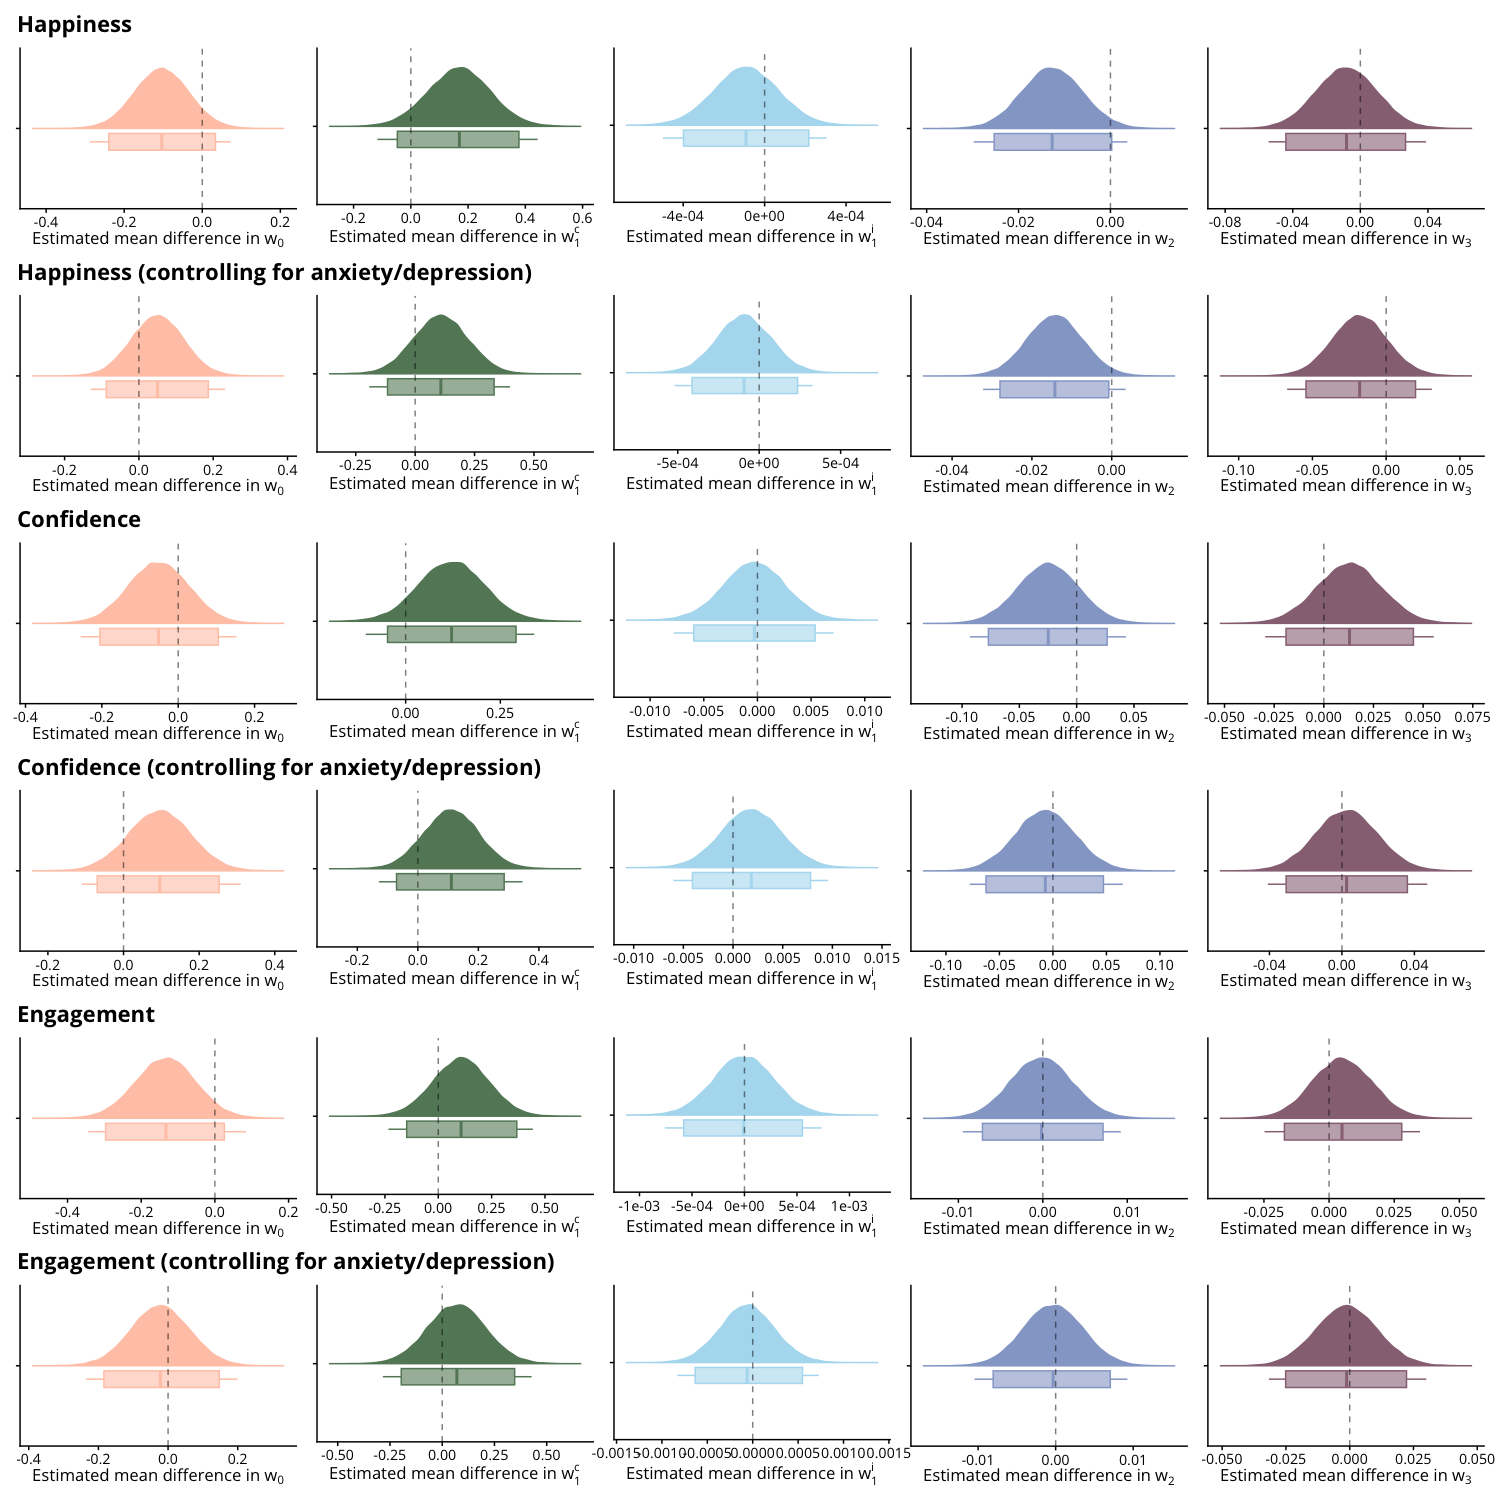

In [53]:
%%R -w 15 -h 15 --units in -r 100

antidep_plt_happy <- pstpipeline::plot_glm(
  antidep_cond_models$happy$no_AD, plot_var = "antidepressant", font = "Open Sans", 
  font_size = 12, pal = pal, ovrll_title = "Happiness"
)
antidep_plt_happy_ad <- pstpipeline::plot_glm(
  antidep_cond_models$happy$AD, plot_var = "antidepressant", font = "Open Sans", 
  font_size = 12, pal = pal, ovrll_title = "Happiness (controlling for anxiety/depression)"
)

antidep_plt_conf <- pstpipeline::plot_glm(
  antidep_cond_models$confident$no_AD, plot_var = "antidepressant", font = "Open Sans", 
  font_size = 12, pal = pal, ovrll_title = "Confidence"
)
antidep_plt_conf_ad <- pstpipeline::plot_glm(
  antidep_cond_models$confident$AD, plot_var = "antidepressant", font = "Open Sans", 
  font_size = 12, pal = pal, ovrll_title = "Confidence (controlling for anxiety/depression)"
)

antidep_plt_bored <- pstpipeline::plot_glm(
  antidep_cond_models$engaged$no_AD, plot_var = "antidepressant", font = "Open Sans", 
  font_size = 12, pal = pal, ovrll_title = "Engagement"
)
antidep_plt_bored_ad <- pstpipeline::plot_glm(
  antidep_cond_models$engaged$AD, plot_var = "antidepressant", font = "Open Sans", 
  font_size = 12, pal = pal, ovrll_title = "Engagement (controlling for anxiety/depression)"
)

antidep_plt_happy / antidep_plt_happy_ad / antidep_plt_conf /
  antidep_plt_conf_ad / antidep_plt_bored / antidep_plt_bored_ad

In the case of antidepressants, meanwhile, participants appeared to place less weight on the most recent expected value when computing happiness ratings, an effect that remained after conditioning on level of current symptoms. There was limited evidence for any other difference between groups. 

In [54]:
%%R
saveRDS(dist_cond_models, "outputs/cmdstan/affect_2a/outcome_glms/distancing_cond_affect_models.RDS")
saveRDS(antidep_cond_models, "outputs/cmdstan/affect_2a/outcome_glms/antidepressant_cond_affect_models.RDS")